In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
import pingouin as pg
from scipy import stats
from scipy.cluster.hierarchy import fcluster

from scipy.cluster.hierarchy import (linkage, optimal_leaf_ordering, leaves_list, dendrogram)
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score
import matplotlib.cm as cm

from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score
import matplotlib.cm as cm

from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

from sklearn.metrics import adjusted_mutual_info_score

In [2]:
fc = pd.read_pickle('../../DerivedData/matrices/functional/correlation.pickle')
gc = pd.read_csv('../../DerivedData/matrices/clustering_GM_reasigned_silhouette.csv', index_col=0)
groups = pd.read_csv('../../DerivedData/matched_subjects_after_cleaning_incomplete.csv', index_col=0)
gc_group = pd.read_pickle('../../DerivedData/matrices/gm/gm_correlome_3groups')
relabeled_encoding=pd.read_csv('../../DerivedData/lookup_parcellation_labels.csv')
ages = pd.read_csv('../../DerivedData/all3groups_with_ages.csv', index_col=0)

/volatile/miniconda3/envs/networks/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
fc_groups = {}

fc_std = {}

#fc_negative = {}
for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    if group == 'PT: Ses1':
        name = 'PT_session1_id'
    elif group == 'PT: Ses2': 
        name = 'PT_session2_id'
    else:
        name = 'FT_session_id'
    fc_ar = []  
    for ses_id in groups[name].values:
        if np.shape(fc[str(int(ses_id))]) == (75,75):
           fc_ar.append(fc[str(int(ses_id))])
    fc_ar = np.array(fc_ar)
    #mean_ar = np.mean(fc_ar, axis=0)
    #fc_negative[group] = mean_ar
    fc_ar[np.where(fc_ar <0)] = 0
    mean_ar = np.mean(fc_ar, axis=0)
    fc_groups[group] = mean_ar
    
    fc_std[group] = np.mean(fc_ar, axis=0)
    
fc_ages = {}
#fc_negative = {}
for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    if group == 'PT: Ses1':
        name = 'PT_session1_id'
    elif group == 'PT: Ses2': 
        name = 'PT_session2_id'
    else:
        name = 'FT_session_id'
    fc_ar = []  
    
    fc_ages[group] = {}
    
    fc_ages[group]['PMA'] = []
    fc_ages[group]['GA'] = []
    
    for ses_id in groups[name].values:
        if np.shape(fc[str(int(ses_id))]) == (75,75):
           fc_ar.append(fc[str(int(ses_id))])
           fc_ages[group]['PMA'].append(ages[ages.session == ses_id]['scan_age '].values[0])
           fc_ages[group]['GA'].append(ages[ages.session == ses_id]['birth_age '].values[0])
        
        
        
    fc_ar = np.array(fc_ar)
    #mean_ar = np.mean(fc_ar, axis=0)
    #fc_negative[group] = mean_ar
    fc_ar[np.where(fc_ar <0)] = 0
    idx = np.triu_indices_from(fc_ar[1], k = 1)
    
    fc_ages[group]['matrix'] = np.array([fc_ar[i][idx] for i in range(len(fc_ar))])
    fc_ages[group]['mean'] = [np.median(fc_ar[i][idx]) for i in range(len(fc_ar))]

In [4]:
def cluster_agglomerative(data,k, method='ward', metric='euclidean', criterion='maxclust'):
    """ performs hierarchical clustering 
    Params:
    data: array (n_samples, n_features)
    k: number of clusters to get
    Returns: (cluster labels, SSE)
    """
    Z1 = linkage(data, method=method, metric=metric)
    f1 = fcluster(Z1, k, criterion=criterion)
    SSE  = []
    for cl in np.unique(f1):
        sub = data[f1==cl]
        centroid = np.mean(sub, axis=0)
        dist = np.sum(np.array([np.linalg.norm(sub[point]  - centroid)**2 for point in np.arange(len(sub))]))
        SSE.append(dist)
    return f1, np.sum(SSE), Z1
   

### ideal cluster number statistics 
def gap(data, nrefs, clusters,  method='ward', metric='euclidean', criterion='maxclust'):
    """ calculates optimal K using Gap statistic 
    Params:
    data: array (n_samples, n_features)
    nrefs: number of reference datasets to create 
    clusters: number of clusters to evaluate for
    Returns: (gaps for given clusters, optimapK)
    """
    gaps = np.zeros_like(clusters)
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    
    for idx, cls in enumerate(clusters):
        ## holder reference dispersion results 
        refDisps = np.zeros(nrefs)
        ## for n references, generate random sample and perform hierarchical clustering & get SSSE
        for run in range(nrefs):
            # create new random reference set
            #randomReference = np.random.random_sample(size=data.shape)
            randomReference =np.random.random_sample(size=data.shape) * (1-(-1)) + (-1)
            # fit the clustering stuff 
            _ , SSE, _ =  cluster_agglomerative(randomReference, k=cls, method=method,
                                             metric=metric, criterion=criterion)
            refDisps[run] = SSE
            
        # dit cluster to original data 
        _ , orig_SSE, _ =  cluster_agglomerative(data, k=cls, method=method, metric=metric, criterion=criterion)
        # calculate gap statistic 
        gap =   np.mean(np.log(refDisps)) - np.log(orig_SSE)
        stds =  np.std(np.log(refDisps))
        gaps[idx] = gap
        resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
    return ( resultsdf, clusters[gaps.argmax()]) # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal



### PCA on input matrices

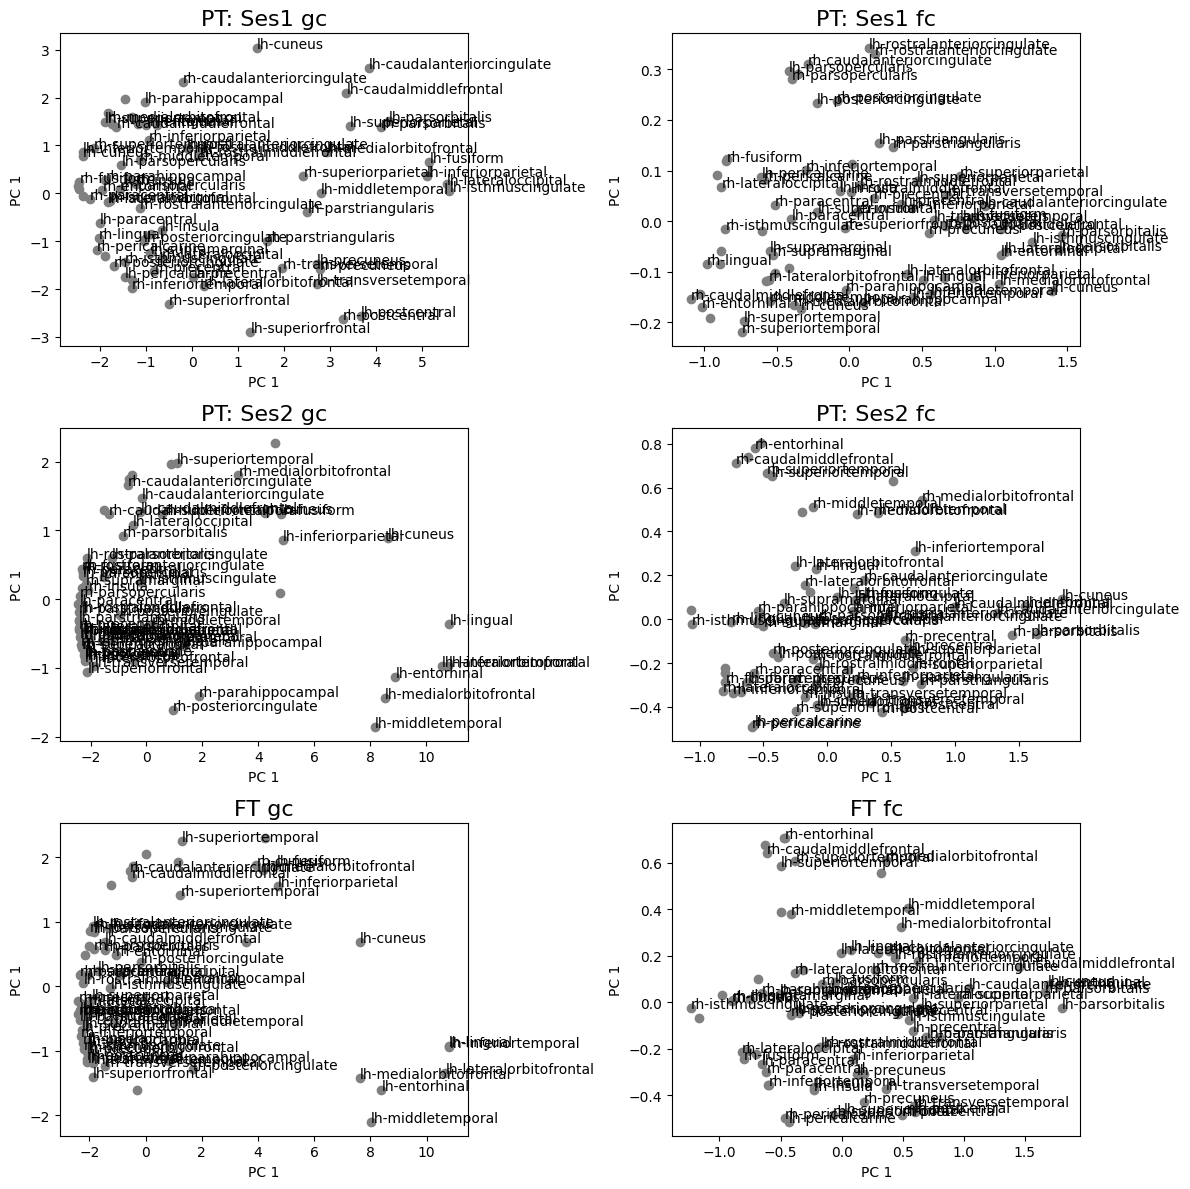

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster 
from sklearn.decomposition import PCA

ig, ax = plt.subplots(3,2, figsize=(12,12), sharex=False, sharey=False)
for g, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    for t, correlome in enumerate(['gc', 'fc']):
        
        if correlome == 'gc':
            data = gc_group[group].values
        else: 
            data = fc_groups[group]
    
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(data)

        ax[g,t].scatter(reduced_data[:,0], reduced_data[:,1], color='gray')

        for i, txt in enumerate(relabeled_encoding['ROI'].values[13:],):
            ax[g,t].annotate(txt, (reduced_data[:,0][i], reduced_data[:,1][i]), fontsize=10)
    
        ax[g,t].set_title('{} {}'.format(group, correlome), fontsize=16)
        ax[g,t].set_xlabel('PC 1')
        ax[g,t].set_ylabel('PC 1')

        plt.tight_layout()
plt.show()

### Clustering Ses1 => (GM, FC) ~ Mutual Information 

In [6]:
clusters['name']

NameError: name 'clusters' is not defined

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
/tmp/ipykernel_27698/1671249035.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'clusterCount':cls, 'gap':gap, 'gap_std':stds}, ignore_index=True)
/tmp/ipykernel_27698/3536232720.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = r

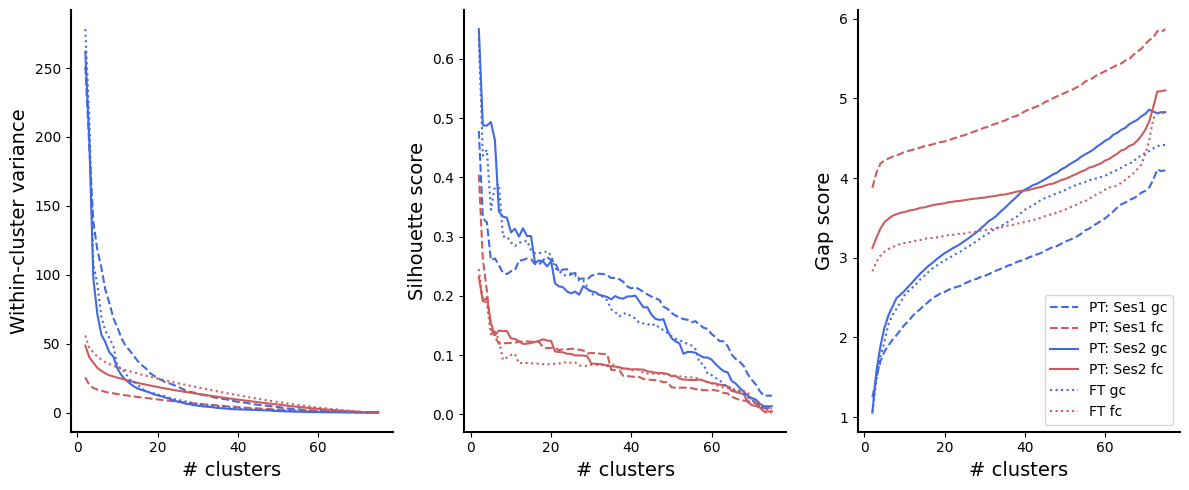

In [7]:
# convert correlation matrix to dissimilarity matrix 
method='ward'
metric='euclidean'
criterion='maxclust'
cls_numbers = np.arange(74)+2
color = 'royalblue'

##################

clusters = pd.DataFrame()
rois = relabeled_encoding['new_label']
clusters['ROI'] = rois
clusters['name'] = relabeled_encoding['ROI']
matrices = {}
        

fig, ax = plt.subplots(1,3, figsize=(12,5)) #, sharey=True, sharex=True)
ax = ax.ravel()

for g, values in enumerate(zip(['PT: Ses1', 'PT: Ses2', 'FT'], ['--','-',':'])):
    
    group = values[0]
    line = values[1]
    for t, correlome in enumerate(['gc', 'fc']):
        if correlome == 'gc':
            color = 'royalblue'
            data = gc_group[group].values
        else: 
            color = 'indianred'  
            data = fc_groups[group]
        
        dissimilarity = 2* (np.sqrt((1-data)))
        Z1 = linkage(dissimilarity, method=method, metric=metric)
        
        matrices['{}_{}_Z'.format(group,correlome)] = Z1
        matrices['{}_{}_D'.format(group,correlome)] = dissimilarity
        
        SSSQ = []
        sil = []

##### clustering part 
        for clustering in cls_numbers:
            f1 = fcluster(Z1, clustering, criterion=criterion)
            clusters['{}_cls_{}_{}'.format(clustering, group,correlome)] = f1
        
            SSQ  = []
            for cl in np.unique(f1):
                sub = data[f1==cl]
                centroid = np.mean(sub, axis=0)
                dist = np.sum(np.array([np.linalg.norm(sub[point]  - centroid)**2 for point in np.arange(len(sub))]))
                SSQ.append(dist)
            SSSQ.append(np.sum(SSQ))
        
            silh = silhouette_score(dissimilarity, f1-1)
            sil.append(silh)
            
        ax[0].plot(cls_numbers, SSSQ, c=color, label=group,linestyle=line)
        ax[0].set_ylabel('Within-cluster variance', fontsize=14)
        ax[0].set_xlabel('# clusters', fontsize=14)
        #ax[0].set_xticks(cls_numbers)
    
    
        ax[1].plot(cls_numbers, sil, c=color, label=group,linestyle=line)
        ax[1].set_ylabel('Silhouette score', fontsize=14)
        ax[1].set_xlabel('# clusters', fontsize=14)
        #ax[1].set_xticks(cls_numbers)
    
        gap_df, optimalK = gap(dissimilarity, 20, cls_numbers, 
                           method=method, metric=metric, criterion=criterion)
        #for i, row in gap_df.iterrows():
        #    if i < len(gap_df)-1:
        #        gap_df.loc[i, 'gap_change'] = gap_df.iloc[i+1].gap - gap_df.iloc[i].gap
        #max_c = gap_df.iloc[gap_df.gap_change.idxmax()+1]['clusterCount']
        #ax[2].vlines(max_c, 1,5, color=color, linestyles='--')        
    
        ax[2].plot(cls_numbers, gap_df['gap'], c=color, label='{} {}'.format(group, correlome), 
                  linestyle=line)
        ax[2].set_ylabel('Gap score', fontsize=14)
        ax[2].set_xlabel('# clusters', fontsize=14)
        #ax[2].set_xticks(cls_numbers)
        ax[2].legend()
        
for x in ax:
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        x.spines[axis].set_linewidth(1.5)
    
plt.tight_layout()
plt.savefig('../../Results/GC_FC_paper/figures/000_GC_FC_group_wise_clustering_quality.jpg', dpi=300)
plt.show()
        

In [8]:
lobe_names = {
    'C': 'Cingular', 
    'F': 'Frontal', 
    'I': 'Insular', 
    'O': 'Occipital', 
    'P': 'Parietal', 
    'S': 'Subcortical', 
    'T': 'Temporal'    
}
lobe_colors = {
    'C': 'tomato', 
    'F': 'cyan', 
    'I': 'lime', 
    'O': 'magenta', 
    'P': 'peru', 
    'S': 'gray', 
    'T': 'goldenrod'  
    
}
lobes=pd.read_csv('../../DerivedData/lookup_parcellation_labels_lobe_grouping.csv')[['new_label', 'ROI', 'lobe']]

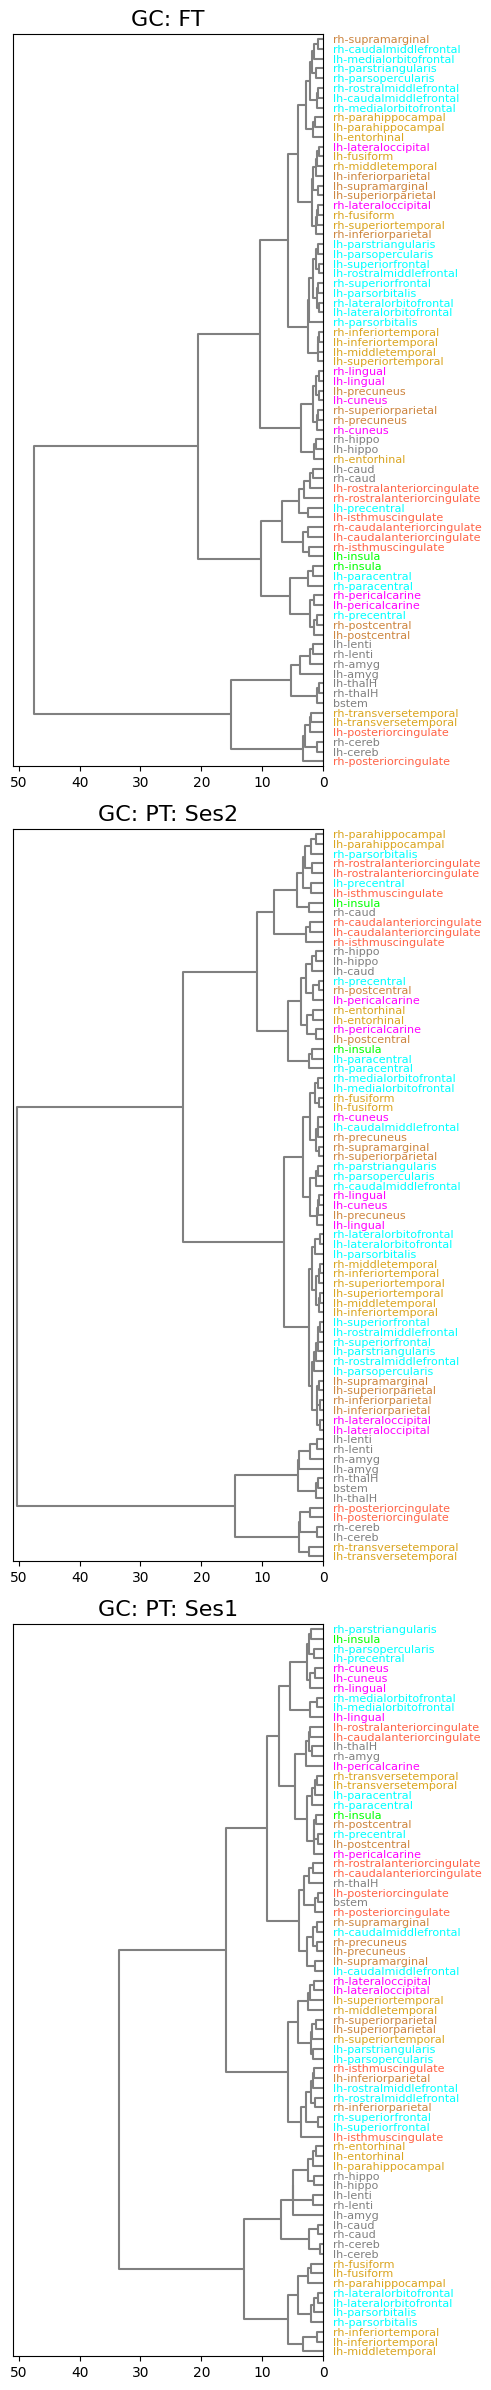

In [9]:
from scipy.cluster.hierarchy import dendrogram

def link_color_func(i):
    #print(i)
    return 'gray'

fig, ax = plt.subplots(3,1, figsize=(5,24), sharey=False, sharex=False)
ax = ax.ravel()

for g, values in enumerate(['FT', 'PT: Ses2', 'PT: Ses1']):

    Z = matrices['{}_gc_Z'.format(values)]
    d = dendrogram(Z, orientation='left', labels=clusters['name'].values, ax = ax[g], 
                  color_threshold=60, link_color_func=link_color_func)
    
    ax[g].set_xlim(51,0)
    ax[g].set_title('GC: {}'.format(values), fontsize=16)
    
    ## changing colours of labels based on the belonfing to the lobe
    for i, tick in enumerate(ax[g].get_yticklabels()):
        text = tick.get_text()
        c_lobe = lobe_colors[lobes[lobes['ROI']  == text].lobe.values[0]]
        plt.setp(ax[g].get_yticklabels()[i], color=c_lobe, fontsize=8)
        
plt.tight_layout()
plt.savefig('../../Results/GC_FC_paper/figures/x_GC_dendrograms.jpg', dpi=600)
plt.show()

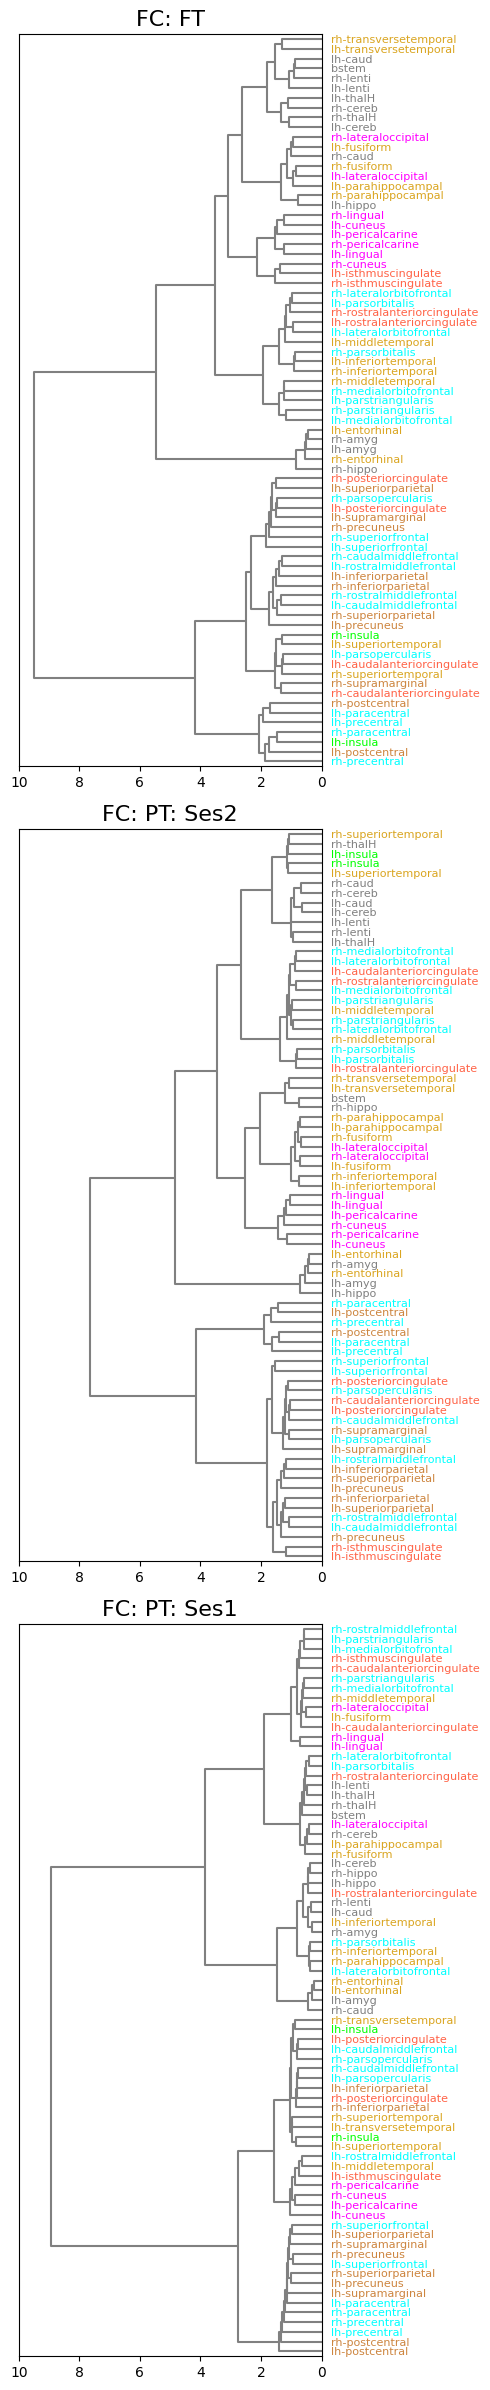

In [10]:
from scipy.cluster.hierarchy import dendrogram

def link_color_func(i):
    #print(i)
    return 'gray'

fig, ax = plt.subplots(3,1, figsize=(5,24), sharey=False, sharex=False)
ax = ax.ravel()

for g, values in enumerate(['FT', 'PT: Ses2', 'PT: Ses1']):

    Z = matrices['{}_fc_Z'.format(values)]
    d = dendrogram(Z, orientation='left', labels=clusters['name'].values, ax = ax[g], 
                  color_threshold=60, link_color_func=link_color_func)
    
    ax[g].set_xlim(10,0)
    ax[g].set_title('FC: {}'.format(values), fontsize=16)
    
    ## changing colours of labels based on the belonfing to the lobe
    for i, tick in enumerate(ax[g].get_yticklabels()):
        text = tick.get_text()
        c_lobe = lobe_colors[lobes[lobes['ROI']  == text].lobe.values[0]]
        plt.setp(ax[g].get_yticklabels()[i], color=c_lobe, fontsize=8)
        
plt.tight_layout()
plt.savefig('../../Results/GC_FC_paper/figures/x_FC_dendrograms.jpg', dpi=600)
plt.show()

In [11]:
clusters.to_csv('../../Results/GC_FC_paper/figures/clustering_for_figures_GC_FC.csv')

### Reassign based on Silhouette score 

In [7]:
clusters_post = pd.DataFrame()
clusters_post['ROI'] = rois
clusters_post['name'] = relabeled_encoding['ROI']

#correction_track = {}

   
for g, values in enumerate(zip(['PT: Ses1', 'PT: Ses2', 'FT'], ['--','-',':'])): 
    group = values[0]
    line = values[1]
    for t, correlome in enumerate(['gc', 'fc']):
        if correlome == 'gc':
            color = 'royalblue'
            #data = gc_group[group].values
        else: 
            color = 'indianred'  
            #data = fc_groups[group]
        
        dissimilarity = matrices['{}_{}_D'.format(group,correlome)]
        
        for y, clustering in enumerate(cls_numbers):
            f1 = clusters['{}_cls_{}_{}'.format(clustering, group,correlome)].values
            sample_silhouette_values = silhouette_samples(dissimilarity, f1)
            print('Pre: {}'.format(silhouette_score(dissimilarity, f1)))
            
            
            ### reasign 
            idx_neg = np.argwhere(sample_silhouette_values < 0)
        
            f2 = f1.copy()
            f2_out = f1.copy()
        
            if len(idx_neg) > 0:
                for idx in idx_neg.ravel():
                    avoid = f1[idx]
                    arg_find = np.argwhere(f1 != avoid).ravel()
                    distances = [euclidean(dissimilarity[idx], dissimilarity[find]) for find in arg_find]
                    new_label = f1[arg_find[np.argmin(distances)]]
                    np.put(f2, idx, new_label)
                
                    if silhouette_score(dissimilarity, f2) > silhouette_score(dissimilarity, f1):
                        np.put(f2_out, idx, new_label)
                        print('correct')
                    else: pass
                
            sample_silhouette_values_post = silhouette_samples(dissimilarity, f2_out) 
            print('Post: {}'.format(silhouette_score(dissimilarity, f2_out)))
            
            clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out       

Pre: 0.4783512538719762
Post: 0.4783512538719762
Pre: 0.33100145887392984
correct
correct
correct
Post: 0.34632680322169485
Pre: 0.32433866774456643
correct
correct
correct
Post: 0.3320085007575231
Pre: 0.26051155710979884
correct
correct
correct
correct
correct
correct
correct
Post: 0.27900988294787216
Pre: 0.26335453116954033
correct
correct
Post: 0.26957341836904136
Pre: 0.2518826733626725
correct
Post: 0.253965394183095
Pre: 0.2388913107956365
correct
correct
correct
Post: 0.250234250946682
Pre: 0.23688086237073566
correct
correct
Post: 0.23983693305998008
Pre: 0.24169815758773353
correct
correct
Post: 0.24703759254985036
Pre: 0.24351968682155586
correct
correct
correct
Post: 0.25061853026468384
Pre: 0.25952377901902857
correct
correct
correct
Post: 0.2637869672260617
Pre: 0.26070164283637887
correct
correct
correct
Post: 0.26650722371975294
Pre: 0.2632418163887992
correct
correct
Post: 0.2716310190058378
Pre: 0.2619238367741942
correct
correct
correct
Post: 0.2646267924332697
Pre:

/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.1094590499997139
Pre: 0.10256397724151611
correct
correct
Post: 0.10490164160728455
Pre: 0.1037498414516449
correct
correct
Post: 0.10568282753229141
Pre: 0.10355815291404724
correct
Post: 0.1039496585726738
Pre: 0.1027105301618576
correct
Post: 0.10324042290449142
Pre: 0.10198604315519333
correct
Post: 0.10226147621870041
Pre: 0.10162629187107086
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.10246368497610092
Pre: 0.07515554130077362
correct
correct
correct
correct
correct
correct
correct
Post: 0.0790344774723053
Pre: 0.07485998421907425
correct
correct
correct
correct
correct
correct
Post: 0.07848399132490158
Pre: 0.07456240057945251
correct
correct
correct
correct
correct
Post: 0.07762984931468964
Pre: 0.06483903527259827
correct
correct
correct
correct
correct
correct
Post: 0.06850931793451309


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Pre: 0.06464574486017227
correct
correct
correct
correct
correct
correct
Post: 0.0683160275220871
Pre: 0.06398245692253113
correct
correct
correct
correct
correct
correct
Post: 0.06752201914787292
Pre: 0.06321939080953598
correct
correct
correct
correct
correct
Post: 0.06766386330127716
Pre: 0.06324311345815659
correct
correct
correct
correct
correct
Post: 0.06807620823383331
Pre: 0.05994320660829544
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

correct
correct
correct
correct
Post: 0.06366775184869766
Pre: 0.059178512543439865
correct
correct
correct
correct
correct
correct
correct
Post: 0.06072124466300011
Pre: 0.05821400508284569
correct
correct
correct
correct
correct
correct
correct
Post: 0.059532687067985535
Pre: 0.05780516192317009
correct
correct
correct
correct
correct
correct
correct
Post: 0.05892679840326309
Pre: 0.056655678898096085
correct
correct
correct
correct
correct
correct
correct
Post: 0.05771753191947937
Pre: 0.05435508117079735
correct
correct
correct
correct
correct
correct
Post: 0.05469220504164696
Pre: 0.054588090628385544
correct
correct
correct
correct
correct
Post: 0.05411174148321152
Pre: 0.045991525053977966
correct
correct
correct
correct
correct
Post: 0.04616585746407509


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Pre: 0.045131389051675797
correct
correct
correct
correct
correct
Post: 0.04616585746407509
Pre: 0.04518851265311241
correct
correct
correct
correct
correct
Post: 0.045518722385168076
Pre: 0.04522526264190674
correct
correct
correct
Post: 0.045932065695524216
Pre: 0.04503527283668518
correct
correct
correct
Post: 0.04574207216501236
Pre: 0.04454309865832329
correct
correct
correct
Post: 0.04524989798665047
Pre: 0.04246687516570091
correct
correct
correct
Post: 0.0436813086271286


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Pre: 0.042380619794130325
correct
Post: 0.04355325177311897
Pre: 0.04097545146942139
correct
Post: 0.042148079723119736
Pre: 0.04062708094716072
correct
correct
Post: 0.04276706650853157
Pre: 0.04175492376089096
correct
Post: 0.04311009496450424
Pre: 0.04049855098128319
correct
Post: 0.04185372218489647
Pre: 0.03950979560613632
Post: 0.03950979560613632
Pre: 0.03627386316657066
correct
Post: 0.03675391897559166
Pre: 0.035507265478372574
Post: 0.035507265478372574
Pre: 0.029927203431725502
Post: 0.029927203431725502
Pre: 0.02703622728586197
Post: 0.02703622728586197
Pre: 0.024749545380473137
Post: 0.024749545380473137
Pre: 0.02343018539249897
Post: 0.02343018539249897
Pre: 0.022538678720593452
Post: 0.022538678720593452
Pre: 0.020231902599334717
Post: 0.020231902599334717
Pre: 0.018795497715473175


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.018795497715473175
Pre: 0.01366181205958128
Post: 0.01366181205958128
Pre: 0.010707259178161621
Post: 0.010707259178161621
Pre: 0.010707259178161621
Post: 0.010707259178161621
Pre: 0.010707259178161621
Post: 0.010707259178161621
Pre: 0.6501885805784375
Post: 0.6501885805784375
Pre: 0.48766869985427785
correct
correct
correct
correct
correct
Post: 0.5107522382981106
Pre: 0.4874063779850183
correct
correct
correct
correct
correct
correct
Post: 0.5117474256643716
Pre: 0.49345382812377125
correct
correct
Post: 0.5053449215613489
Pre: 0.4630687490906996
Post: 0.4630687490906996
Pre: 0.34252090232902244
correct
correct
correct
correct
Post: 0.3534643887719901
Pre: 0.33375332000578556
correct
correct
correct
correct
correct
Post: 0.3413522888283759
Pre: 0.33206888080477404
correct
correct
Post: 0.3494155089128241
Pre: 0.30740175825598204
correct
correct
Post: 0.3247483863640321
Pre: 0.31331992212896487
correct
correct
Post: 0.33066655023701486
Pre: 0.30017725660617883
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

correct
correct
correct
Post: 0.32533691605952325
Pre: 0.30100380165074164
correct
correct
Post: 0.318890768847227
Pre: 0.25538730504355206
correct
Post: 0.2599549661571976
Pre: 0.25986564236820103
correct
Post: 0.2641861395430367
Pre: 0.25834167573731304
correct
correct
correct
Post: 0.2642463814282657
Pre: 0.24985059815283725
correct
correct
correct
Post: 0.2557553038437899
Pre: 0.2583080408211303
correct
Post: 0.2626285379959659
Pre: 0.2209376756539589
Post: 0.2209376756539589
Pre: 0.21613834072859603
Post: 0.21613834072859603
Pre: 0.21449512509055077
Post: 0.21449512509055077
Pre: 0.2073243035796181
Post: 0.2073243035796181
Pre: 0.20440271746235805
Post: 0.20440271746235805
Pre: 0.207369006152725
correct
correct
Post: 0.20859876784164422
Pre: 0.20197060228566385
correct
correct
Post: 0.20320036397458308
Pre: 0.21657107001008935
correct
correct
Post: 0.21779773513046582
Pre: 0.21169265140340537
correct
correct
Post: 0.21291931652378188
Pre: 0.20784895869315023
correct
correct
Post: 

/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

correct
correct
correct
correct
correct
Post: 0.20302971547552345
Pre: 0.19418898310466678
correct
correct
correct
correct
correct
Post: 0.19908507400871
Pre: 0.19976388986370114
correct
Post: 0.1997155892532925
Pre: 0.19640478251165577
correct
Post: 0.19635648190124716
Pre: 0.19540305952623188
correct
Post: 0.19535475891582327
Pre: 0.19910993454892711
correct
Post: 0.19896080105730748
Pre: 0.19933358756168199
correct
correct
Post: 0.20239270208287932
Pre: 0.20041795096068454
correct
Post: 0.20524524469708907
Pre: 0.1905921720072089
correct
Post: 0.19541946574361344
Pre: 0.1808790304732913
correct
Post: 0.1857063242096958
Pre: 0.1809398914255677
correct
correct
Post: 0.18628757849946367
Pre: 0.168618122368017
correct
correct
correct
Post: 0.17723637247209093
Pre: 0.16134606980856114
correct
correct
correct
Post: 0.1699643199126351
Pre: 0.15957596890269754
correct
correct
correct
Post: 0.16956900764358654
Pre: 0.16056365683344317
correct
Post: 0.1631770142584306
Pre: 0.14164041975317052

/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.025108918383048053
Pre: 0.01811817201592935
Post: 0.01811817201592935
Pre: 0.013772190117860041
Post: 0.013772190117860041
Pre: 0.013772190117860041
Post: 0.013772190117860041
Pre: 0.013772190117860041
Post: 0.013772190117860041
Pre: 0.2319749891757965
Post: 0.2319749891757965
Pre: 0.19073303043842316
Post: 0.19073303043842316
Pre: 0.1972120702266693
Post: 0.1972120702266693
Pre: 0.15420199930667877
correct
Post: 0.15469957888126373
Pre: 0.13363219797611237
correct
correct
correct
correct
correct
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.13829366862773895
Pre: 0.14171303808689117
Post: 0.14171303808689117
Pre: 0.14056748151779175
correct
Post: 0.14347529411315918
Pre: 0.1407763510942459
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.14525873959064484
Pre: 0.12820525467395782
correct
correct
correct
Post: 0.132168248295784
Pre: 0.12753048539161682
correct
correct
correct
Post: 0.13149666786193848
Pre: 0.1233832910656929
correct
correct
correct
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.12810468673706055
Pre: 0.11912129819393158
correct
correct
correct
correct
correct
Post: 0.11987601965665817
Pre: 0.11943453550338745
correct
correct
correct
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out


Post: 0.12019643187522888
Pre: 0.12049166113138199
correct
correct
correct
correct
correct
Post: 0.12285824865102768
Pre: 0.12252724915742874
correct
correct
correct
correct
correct
Post: 0.12490234524011612
Pre: 0.12403031438589096
correct
correct
correct
correct
correct
Post: 0.1261167824268341
Pre: 0.12687702476978302
correct
correct
correct
correct
correct
Post: 0.12748321890830994


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Pre: 0.12468960136175156
correct
correct
correct
correct
correct
Post: 0.1250847429037094
Pre: 0.12399283051490784
correct
correct
correct
correct
correct
Post: 0.1243802160024643
Pre: 0.10614863783121109
Post: 0.10614863783121109
Pre: 0.10544613748788834
Post: 0.10544613748788834
Pre: 0.10485228151082993
Post: 0.10485228151082993
Pre: 0.10233676433563232
correct
Post: 0.10342137515544891
Pre: 0.10220787674188614


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out


Post: 0.10220787674188614
Pre: 0.09944132715463638
correct
Post: 0.10074588656425476
Pre: 0.09974494576454163
correct
Post: 0.1010494977235794
Pre: 0.09940913319587708
correct
Post: 0.10071369260549545
Pre: 0.09829310327768326
correct
Post: 0.09973769634962082
Pre: 0.08609841763973236
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.09484631568193436
Pre: 0.0854572132229805
correct
correct
Post: 0.0942050963640213
Pre: 0.08516746014356613
correct
correct
Post: 0.09391535073518753
Pre: 0.08440450578927994
correct
correct
Post: 0.0915725976228714
Pre: 0.0818919986486435
correct
correct
Post: 0.08931078761816025
Pre: 0.08141276240348816
correct
correct
Post: 0.08883154392242432
Pre: 0.08075782656669617
correct
correct
Post: 0.08817661553621292
Pre: 0.07974894344806671
correct
correct
Post: 0.08690056204795837


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Pre: 0.0775451511144638
correct
correct
Post: 0.08535228669643402
Pre: 0.07740821689367294
correct
correct
Post: 0.08521535992622375
Pre: 0.07586788386106491
correct
correct
Post: 0.08367501944303513
Pre: 0.07641882449388504
Post: 0.07641882449388504
Pre: 0.07590708136558533
Post: 0.07590708136558533
Pre: 0.07571668922901154
Post: 0.07571668922901154
Pre: 0.07262898981571198
Post: 0.07262898981571198
Pre: 0.0719769150018692
correct
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.0731574147939682
Pre: 0.07040255516767502
correct
correct
correct
Post: 0.07158306241035461
Pre: 0.06983638554811478
correct
correct
correct
Post: 0.07101689279079437
Pre: 0.06970171630382538
correct
correct
Post: 0.07043372839689255
Pre: 0.06827890872955322
correct
correct
Post: 0.06901092827320099
Pre: 0.06457206606864929
correct
correct
correct
correct
Post: 0.05966811999678612
Pre: 0.06524312496185303
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

correct
Post: 0.06356137990951538
Pre: 0.060313884168863297
correct
correct
Post: 0.05825819820165634
Pre: 0.05882268399000168
correct
correct
Post: 0.05658455565571785
Pre: 0.05861467495560646
correct
Post: 0.056408196687698364
Pre: 0.05803123489022255
correct
Post: 0.05582475662231445
Pre: 0.05810379609465599
Post: 0.05810379609465599
Pre: 0.05890632048249245
Post: 0.05890632048249245
Pre: 0.056975338608026505
Post: 0.056975338608026505
Pre: 0.054510459303855896
Post: 0.054510459303855896
Pre: 0.05289264768362045
Post: 0.05289264768362045
Pre: 0.052149176597595215
Post: 0.052149176597595215
Pre: 0.05029979720711708
Post: 0.05029979720711708


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Pre: 0.049443624913692474
Post: 0.049443624913692474
Pre: 0.04732106998562813
Post: 0.04732106998562813
Pre: 0.03965459764003754
Post: 0.03965459764003754
Pre: 0.03802599385380745
Post: 0.03802599385380745
Pre: 0.03591400757431984
Post: 0.03591400757431984
Pre: 0.034478504210710526
Post: 0.034478504210710526
Pre: 0.021096596494317055
Post: 0.021096596494317055
Pre: 0.015750503167510033
Post: 0.015750503167510033
Pre: 0.014217862859368324
Post: 0.014217862859368324
Pre: 0.011762164533138275
Post: 0.011762164533138275
Pre: 0.005099446978420019
Post: 0.005099446978420019
Pre: 0.005099446978420019
Post: 0.005099446978420019
Pre: 0.005099446978420019
Post: 0.005099446978420019
Pre: 0.6337846913025164
Post: 0.6337846913025164
Pre: 0.4368811162179445
correct
correct
correct
correct
Post: 0.45881396461650986
Pre: 0.4465201528628545
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

correct
correct
Post: 0.47490591202646726
Pre: 0.3453171455191824
correct
correct
correct
correct
correct
correct
correct
correct
correct
Post: 0.3736243611634104
Pre: 0.38496807572499786
correct
correct
correct
correct
correct
correct
Post: 0.39703038410588554
Pre: 0.38868677852254147
correct
correct
correct
Post: 0.4001745248315248
Pre: 0.3000157343032465
correct
correct
correct
correct
Post: 0.3131809246955653
Pre: 0.30046320820254147
correct
correct
correct
Post: 0.31006130973971185
Pre: 0.29046950284454404
correct
correct
correct
Post: 0.3000676043817145
Pre: 0.2841820905286173
Post: 0.2841820905286173
Pre: 0.2898396961884985
Post: 0.2898396961884985
Pre: 0.2911791264995301
Post: 0.2911791264995301
Pre: 0.29337636956344987
Post: 0.29337636956344987
Pre: 0.2774350000156026
Post: 0.2774350000156026
Pre: 0.27192346420127306
Post: 0.27192346420127306
Pre: 0.2721711257148097
correct
Post: 0.2769224195150065
Pre: 0.2731946171897064
correct
Post: 0.27794591098990323
Pre: 0.27545343674272

/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

correct
correct
Post: 0.2421293488776019
Pre: 0.23501691605060074
correct
correct
Post: 0.24124165783625764
Pre: 0.22585032179619063
correct
correct
Post: 0.23207506358184754
Pre: 0.22623962738128023
correct
correct
Post: 0.2324643691669371
Pre: 0.21557813596727096
correct
correct
Post: 0.22180287775292787
Pre: 0.2035228606013608
correct
correct
correct
correct
correct
correct
Post: 0.21199379553958028
Pre: 0.20105183762849374
correct
correct
correct
correct
correct
correct
Post: 0.20952277256671328
Pre: 0.20369960569812498
correct
correct
correct
correct
Post: 0.21003299996016064
Pre: 0.1971602066643394
correct
correct
Post: 0.20162963583489932
Pre: 0.19241460539993688
correct
Post: 0.1995628566713102
Pre: 0.17738225309478972
correct
Post: 0.18453050436616303
Pre: 0.17291465998856284
correct
Post: 0.18006291125993612
Pre: 0.16557938410266207
correct
Post: 0.1727276353740354
Pre: 0.1702574821827823
correct
Post: 0.17411829293786701
Pre: 0.17050662784225026
correct
Post: 0.1726917281857

/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

correct
Post: 0.1259561678990533
Pre: 0.11618600121137163
correct
correct
Post: 0.11880273827909443
Pre: 0.10993148040948171
correct
correct
Post: 0.11254821747720452
Pre: 0.08741220613511655
correct
correct
Post: 0.09002894320283938
Pre: 0.08438356444210204
correct
correct
Post: 0.08700030150982488
Pre: 0.06871599111784155
correct
correct
Post: 0.07133272818556437
Pre: 0.06637950911078472
correct
Post: 0.0734201353407798
Pre: 0.06180604393163826
correct
Post: 0.07023216732989858
Pre: 0.05809866242328725
correct
Post: 0.06652478582154757
Pre: 0.05065140540754514
correct
Post: 0.059077528805805454
Pre: 0.04835946921619315
correct
Post: 0.05678559261445347
Pre: 0.04346510446060524
correct
Post: 0.05189122785886557
Pre: 0.03975885218245702
correct
Post: 0.048145929697906396
Pre: 0.03940770098206085
Post: 0.03940770098206085
Pre: 0.03478336674257721
Post: 0.03478336674257721
Pre: 0.02891874107200032
Post: 0.02891874107200032
Pre: 0.023630546792347048
Post: 0.023630546792347048
Pre: 0.02101

/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.1897141933441162
Pre: 0.13497920334339142
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
Post: 0.1384086012840271
Pre: 0.13977347314357758
correct
correct
correct
correct
correct
correct
Post: 0.14040915668010712
Pre: 0.12610973417758942


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.12610973417758942
Pre: 0.09202196449041367
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
Post: 0.10072967410087585
Pre: 0.09607820957899094
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out


correct
correct
correct
correct
Post: 0.10479855537414551
Pre: 0.10010644793510437
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
Post: 0.10484308749437332
Pre: 0.10235346108675003
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out


correct
correct
correct
correct
correct
correct
correct
correct
correct
Post: 0.10964889824390411
Pre: 0.08609578013420105
correct
correct
correct
correct
correct
correct
correct
Post: 0.09480822086334229
Pre: 0.08711454272270203
correct
correct
correct
correct
correct
correct
Post: 0.0954815074801445
Pre: 0.08664333075284958
correct
correct
correct
correct
correct
correct
correct
correct
Post: 0.09535060077905655
Pre: 0.08619523793458939


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

correct
correct
correct
correct
correct
correct
correct
correct
Post: 0.09406664222478867
Pre: 0.08597681671380997
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
Post: 0.089872807264328
Pre: 0.08573096245527267
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out


correct
correct
correct
correct
correct
correct
correct
correct
correct
Post: 0.08753881603479385
Pre: 0.08498081564903259
correct
correct
correct
Post: 0.08611603081226349
Pre: 0.08482322096824646
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

correct
Post: 0.0859600305557251
Pre: 0.08447397500276566
correct
correct
correct
correct
correct
correct
Post: 0.08403280377388
Pre: 0.08543454855680466
correct
correct


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

correct
correct
correct
correct
Post: 0.0867764949798584
Pre: 0.08598233759403229
correct
correct
correct
correct
correct
correct
Post: 0.08837290108203888
Pre: 0.08686549216508865
correct
correct
correct
correct
correct
correct
Post: 0.08688356727361679
Pre: 0.0889081135392189


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

correct
correct
Post: 0.09156268835067749
Pre: 0.0870128944516182
correct
correct
Post: 0.0896475538611412
Pre: 0.08766734600067139
correct
correct
Post: 0.09010302275419235
Pre: 0.08261037617921829
Post: 0.08261037617921829
Pre: 0.08198917657136917


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out


Post: 0.08198917657136917
Pre: 0.08207988739013672
correct
Post: 0.08326702564954758
Pre: 0.08355232328176498
correct
Post: 0.08446018397808075
Pre: 0.08333879709243774


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.08333879709243774
Pre: 0.08333905041217804
Post: 0.08333905041217804
Pre: 0.08335738629102707
Post: 0.08335738629102707
Pre: 0.08308758586645126
Post: 0.08308758586645126
Pre: 0.083875373005867
Post: 0.083875373005867
Pre: 0.08392389863729477
Post: 0.08392389863729477
Pre: 0.07574234157800674


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.07574234157800674
Pre: 0.07782543450593948
Post: 0.07782543450593948
Pre: 0.0763249546289444
Post: 0.0763249546289444
Pre: 0.07499081641435623
Post: 0.07499081641435623
Pre: 0.0739993304014206


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.0739993304014206
Pre: 0.07633688300848007
Post: 0.07633688300848007
Pre: 0.07002349942922592
Post: 0.07002349942922592
Pre: 0.06918331980705261
Post: 0.06918331980705261
Pre: 0.06952851265668869


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Post: 0.06952851265668869
Pre: 0.06823469698429108
Post: 0.06823469698429108
Pre: 0.06856552511453629
Post: 0.06856552511453629
Pre: 0.06801507622003555
correct
correct
correct
Post: 0.06892921775579453
Pre: 0.06774000823497772
correct
correct
correct
Post: 0.06892921775579453
Pre: 0.0653609186410904
correct
correct
correct
Post: 0.0665501281619072
Pre: 0.06510145962238312
correct
Post: 0.06617920845746994
Pre: 0.06427429616451263
correct
Post: 0.06535204499959946
Pre: 0.06378410011529922
correct
Post: 0.06411777436733246


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Pre: 0.06247270107269287
correct
Post: 0.0632186084985733
Pre: 0.062491416931152344
Post: 0.062491416931152344
Pre: 0.06205199658870697
Post: 0.06205199658870697
Pre: 0.05863768234848976
Post: 0.05863768234848976
Pre: 0.05753762647509575
Post: 0.05753762647509575
Pre: 0.054443322122097015
Post: 0.054443322122097015
Pre: 0.05252116546034813
Post: 0.05252116546034813
Pre: 0.05007096007466316
correct
correct
Post: 0.05172387883067131
Pre: 0.04730399325489998
correct
Post: 0.049292031675577164
Pre: 0.045569248497486115
correct
Post: 0.04615123197436333
Pre: 0.04477319121360779
correct
Post: 0.045194581151008606


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Pre: 0.043569859117269516
correct
Post: 0.04399125277996063
Pre: 0.041919559240341187
correct
Post: 0.042229797691106796
Pre: 0.03988084942102432
Post: 0.03988084942102432
Pre: 0.039099495857954025
Post: 0.039099495857954025
Pre: 0.03830166161060333
Post: 0.03830166161060333
Pre: 0.02362903021275997
Post: 0.02362903021275997
Pre: 0.02138577215373516
Post: 0.02138577215373516
Pre: 0.01691121980547905
Post: 0.01691121980547905
Pre: 0.003193377051502466
Post: 0.003193377051502466
Pre: 0.003193377051502466
Post: 0.003193377051502466
Pre: 0.003193377051502466
Post: 0.003193377051502466


/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters_post['{}_cls_{}_{}'.format(clustering, group,correlome)] = f2_out
/tmp/ipykernel_26080/2592614150.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

### TRY TO PLOT DENDOGRAMS WITH THE 'BEST' MATCH
=> do on non re-labeled data

In [8]:
from sklearn.metrics.cluster import contingency_matrix
from scipy.spatial.distance import dice
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

In [9]:
clusters

ROI                   name  2_cls_PT: Ses1_gc  3_cls_PT: Ses1_gc  \
0     1               lh-hippo                  1                  1   
1     2               rh-hippo                  1                  1   
2     3                lh-amyg                  1                  1   
3     4                rh-amyg                  2                  3   
4     5               lh-cereb                  1                  1   
..  ...                    ...                ...                ...   
70   71    rh-superiorparietal                  2                  2   
71   72    rh-superiortemporal                  2                  2   
72   73       rh-supramarginal                  2                  3   
73   74  rh-transversetemporal                  2                  3   
74   75              rh-insula                  2                  3   

    4_cls_PT: Ses1_gc  5_cls_PT: Ses1_gc  6_cls_PT: Ses1_gc  \
0                   2                  2                  2   
1                   2                  2                  2   
2                   2                  2                  2   
3                   4                  5                  5   
4                   2                  2                  2   
..                ...                ...                ...   
70                  3                  3                  3   
71                  3                  3                  3   
72                  4                  4                  4   
73                  4                  5                  5   
74                  4                  5                  5   

    7_cls_PT: Ses1_gc  8_cls_PT: Ses1_gc  9_cls_PT: Ses1_gc  ...  \
0                   3                  3                  4  ...   
1                   3                  3                  4  ...   
2                   3                  3                  4  ...   
3                   6                  7                  8  ...   
4                   2                  2                  3  ...   
..                ...                ...                ...  ...   
70                  4                  5                  6  ...   
71                  4                  5                  6  ...   
72                  5                  6                  7  ...   
73                  6                  7                  8  ...   
74                  6                  7                  8  ...   

    66_cls_FT_fc  67_cls_FT_fc  68_cls_FT_fc  69_cls_FT_fc  70_cls_FT_fc  \
0             53            53            54            54            55   
1             31            31            31            31            32   
2             31            31            31            31            31   
3             31            31            31            31            31   
4             59            59            60            60            61   
..           ...           ...           ...           ...           ...   
70            17            17            17            17            17   
71            12            12            12            12            12   
72             9             9             9             9             9   
73            66            67            68            69            70   
74            14            14            14            14            14   

    71_cls_FT_fc  72_cls_FT_fc  73_cls_FT_fc  74_cls_FT_fc  75_cls_FT_fc  
0             55            55            56            56            56  
1             32            32            33            33            33  
2             31            31            31            31            31  
3             31            31            31            31            31  
4             62            63            64            64            64  
..           ...           ...           ...           ...           ...  
70            17            17            17            17            17  
71            12            12            12        

In [10]:
#relabeled_clust_res = clusters_post.copy()
relabeled_clust_res = clusters.copy()
res_clas = {}

res_clas['acc'] = []
res_clas['prec'] = []
res_clas['rec'] = []

for group in ['FT']:
    
    res_clas[group] ={}
    res_clas[group]['acc'] = []
    res_clas[group]['prec'] = []
    res_clas[group]['rec'] = []


    for cls in cls_numbers[:19]:
        gc_labels = clusters['{}_cls_{}_gc'.format(cls, group)].values
        fc_labels = clusters['{}_cls_{}_fc'.format(cls, group)].values
        cont_m = contingency_matrix(gc_labels, fc_labels)
    
        ### test 
        #gc_labels = clusters_post['{}_cls_FT_gc'.format(len(cont_m))].values
        #fc_labels = clusters_post['{}_cls_FT_fc'.format(len(cont_m))].values
        fc_relabel= np.zeros_like(fc_labels)

    
        max_matches = [ np.argmax(cont_m[:,i]) for i in range(len(cont_m)) ]
        max_coutns = [cont_m[np.argmax(cont_m[:,i]), i] for i in range(len(cont_m))]

        unique = np.unique(fc_labels)

        new_matches = np.array(max_matches.copy())
    
        pairing_dict = {}
        for match in np.unique(max_matches):
            if len(np.where(max_matches == match)[0]) > 1:
                match_idx = np.argwhere(max_matches == match)[:,0]          
                a = np.array(max_coutns)[np.where(max_matches == match)[0]]
                idx = np.where(a !=  np.max(a))[0]
                #print('IDX', idx)
                if len(idx) > 0:
                    to_remove = match_idx[idx]
                    new_matches[to_remove] = 999
                else: 
                    #print('correcting')
                    #print(a)
                    idx = np.where(a ==  np.max(a))[0]
                    #print('idx', idx)
                    to_remove = match_idx[idx[:-1]]
                    new_matches[to_remove] = 999
                    #print('correcting')
                    #print(match, to_remove)
  
        matching_labels = new_matches + 1         
        new_other = unique[~ np.isin(unique, matching_labels)]
        
        try:
            matching_labels[matching_labels == 1000 ] = new_other
            for i in range(len(cont_m)):
                fc_relabel[fc_labels == matching_labels[i]] = i+1     
            relabeled_clust_res['{}_cls_{}_fc'.format(cls, group)] = fc_relabel    
    
            res_clas[group]['acc'].append(balanced_accuracy_score(fc_relabel, gc_labels))
            res_clas[group]['prec'].append(precision_score(fc_relabel, gc_labels, average='weighted'))
            res_clas[group]['rec'].append(recall_score(fc_relabel, gc_labels, average='weighted'))
            
        except:
            res_clas[group]['acc'].append(0)
            res_clas[group]['prec'].append(0)
            res_clas[group]['rec'].append(0)
            
            matching_labels[matching_labels == 1000 ] = new_other[:len(matching_labels[matching_labels == 1000 ])]
            for i in range(len(cont_m)):
                fc_relabel[fc_labels == matching_labels[i]] = i+1     
            relabeled_clust_res['{}_cls_{}_fc'.format(cls, group)] = fc_relabel  
          

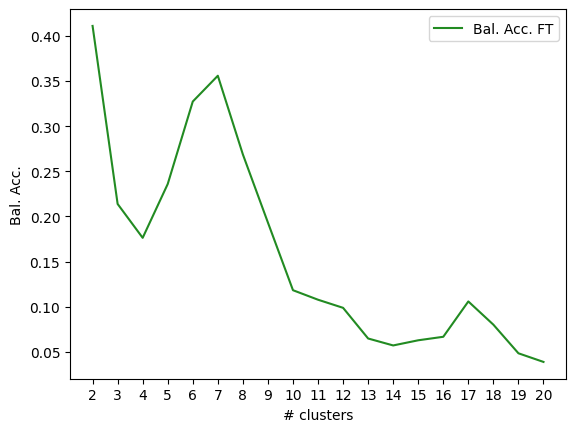

In [11]:
for metric in ['acc']:#, 'prec', 'rec']:
    
    if metric == 'acc':
        name = 'Bal. Acc.'
        line = '-'
    elif metric == 'prec':
        name = 'Precision'
        line = '--'
    else: 
        name = 'Recall'
        line = '-.'

    for group  in ['FT']:
        if group == 'FT':
            color = 'forestgreen'

        else: 
            color = 'darkmagenta'
    
        plt.plot(cls_numbers[:19], res_clas[group][metric], label=name + ' ' +group, color=color, linestyle= line)
    
plt.xticks(cls_numbers[:19])
plt.legend()
plt.xlabel('# clusters')
plt.ylabel(name)
plt.show()

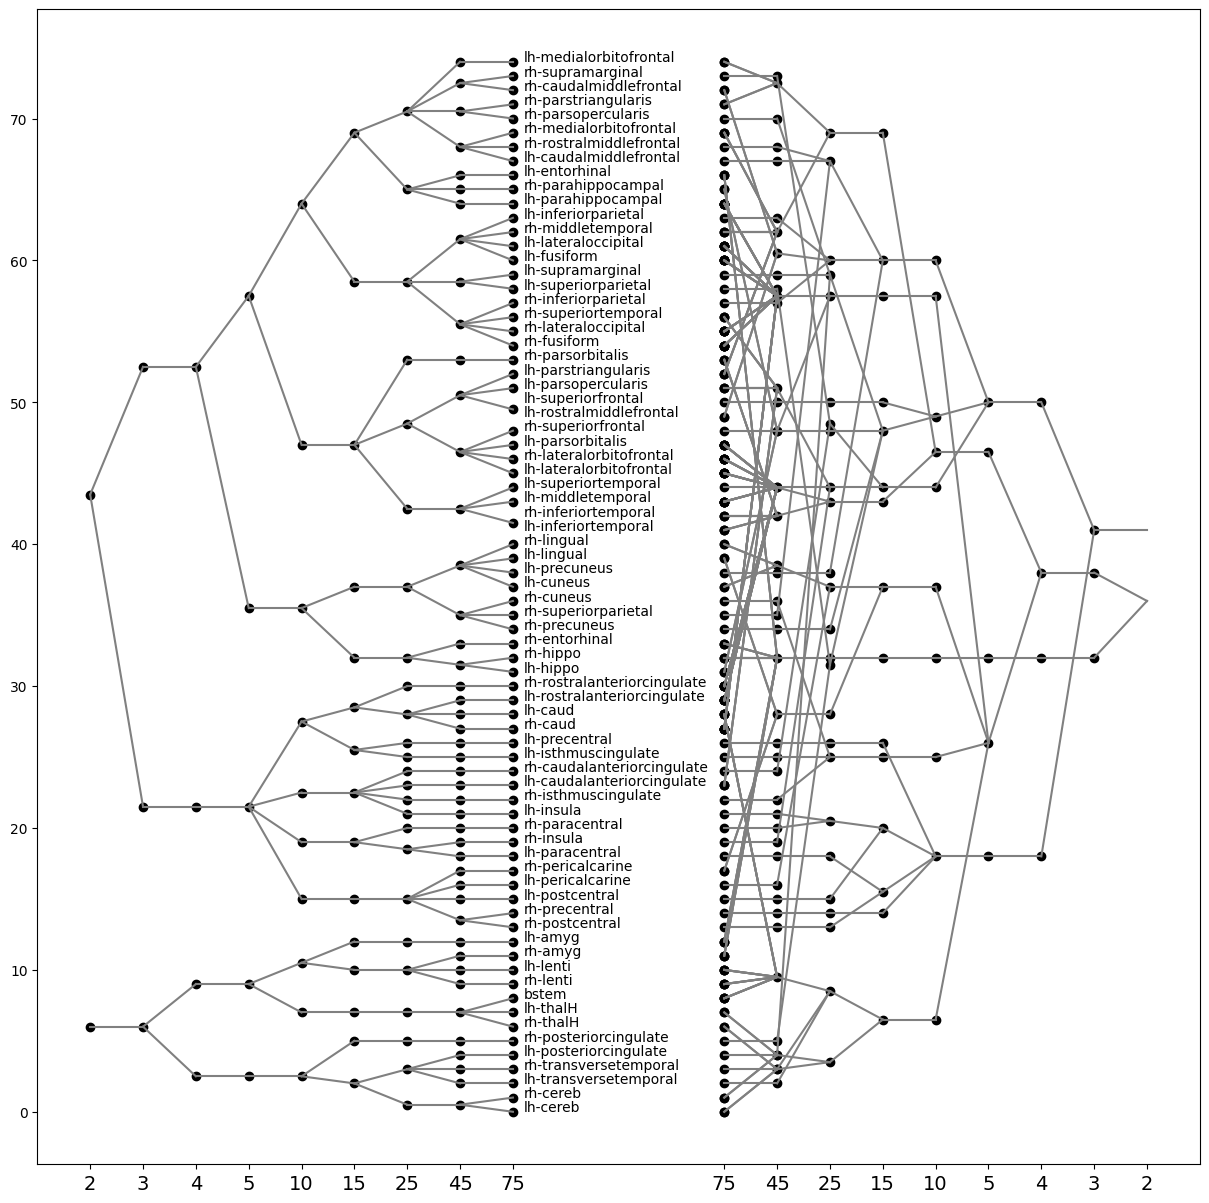

In [21]:
from scipy.stats import mode 
import random

correlome = 'gc'
group = 'FT'


columns = ['{}_cls_{}_{}'.format(cls, group, correlome) for cls in cls_numbers for correlome in ['fc', 'gc']]
columns.append('name')

a = relabeled_clust_res.copy()
a = a[columns].sort_values(['{}_cls_{}_{}'.format(cls, group, 'gc') for cls in cls_numbers])
a.reset_index(drop=True, inplace=True)

number_of_colors = 75
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


color = ['blue', 'red', 'magenta', 'gray', 'brown', 'gold', 'black', 'aqua', 'orange', 'lime']

color = np.empty_like(color)
color[:] = 'gray'

whole = np.arange(len(rois))
plt.figure(figsize=(15,15))

#plt.plot([np.zeros_like(whole), np.ones_like(whole)], 
#         [whole,whole], color='gray')

points = [75,45,25,15,10,5,4,3,2]

correlome= 'gc'
for y, c in enumerate(points):
    #print(np.unique(a['{}_cls_FT_gc'.format(c)].values))
    for cluster in np.unique(a['{}_cls_{}_{}'.format(c, group, correlome )].values):
        
        idx = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster].index
        m = np.median(idx)
        #plt.vlines(-y, np.min(idx), np.max(idx), 'gray')
        
        if c != 2:
            previous = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster]['{}_cls_{}_{}'.format(points[y+1], group, correlome)].values
            previous = mode(previous, keepdims=True)[0][0]
            idx = a[a['{}_cls_{}_{}'.format(points[y+1], group, correlome)] == previous].index
            previous_m = np.median(idx)
            
            root = previous = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster]['{}_cls_{}_{}'.format(5, group, correlome)].values
            root = mode(root, keepdims=True)[0][0]
            
            
            #plt.hlines(m, -y, -y-1 , color[int(root)-1])
            #plt.vlines(-y-1, m, previous_m ,color[int(root)-1])
            
            plt.plot([-y, -y-1], [m, previous_m] ,color[int(root)-1])
            
            
        plt.scatter(-y, m,color='black')


correlome = 'fc'
for y, c in enumerate(points):
    #print(np.unique(a['{}_cls_FT_gc'.format(c)].values))
    for cluster in np.unique(a['{}_cls_{}_{}'.format(c, group, correlome )].values):
        idx = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster].index
        m = np.median(idx)
        #plt.vlines(-y, np.min(idx), np.max(idx), 'gray')
        
        if c != 2:
            previous = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster]['{}_cls_{}_{}'.format(points[y+1], group, correlome)].values
            previous = mode(previous, keepdims=True)[0][0]
            idx = a[a['{}_cls_{}_{}'.format(points[y+1], group, correlome)] == previous].index
            previous_m = np.median(idx)
            
            root = previous = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster]['{}_cls_{}_{}'.format(5, group, correlome)].values
            root = mode(root, keepdims=True)[0][0]
        
            if c == 75 and len(idx) > 1: 
                for each in idx:
                    plt.plot([y+4, y+5], [each, previous_m] ,color[int(root)-1])
                    plt.scatter(y+4, each ,color='black')
            else: 
                    plt.plot([y+4, y+5], [m, previous_m] ,color[int(root)-1])
                    plt.scatter(y+4, m,color='black')

x_labels = np.concatenate([np.arange(len(points))*-1, np.arange(len(points))+4])                   
plt.xticks(x_labels, np.concatenate([points, points]), fontsize=14)        
        
for i, row in a.iterrows():
    plt.annotate(row['name'], (0.2,i))
plt.show()


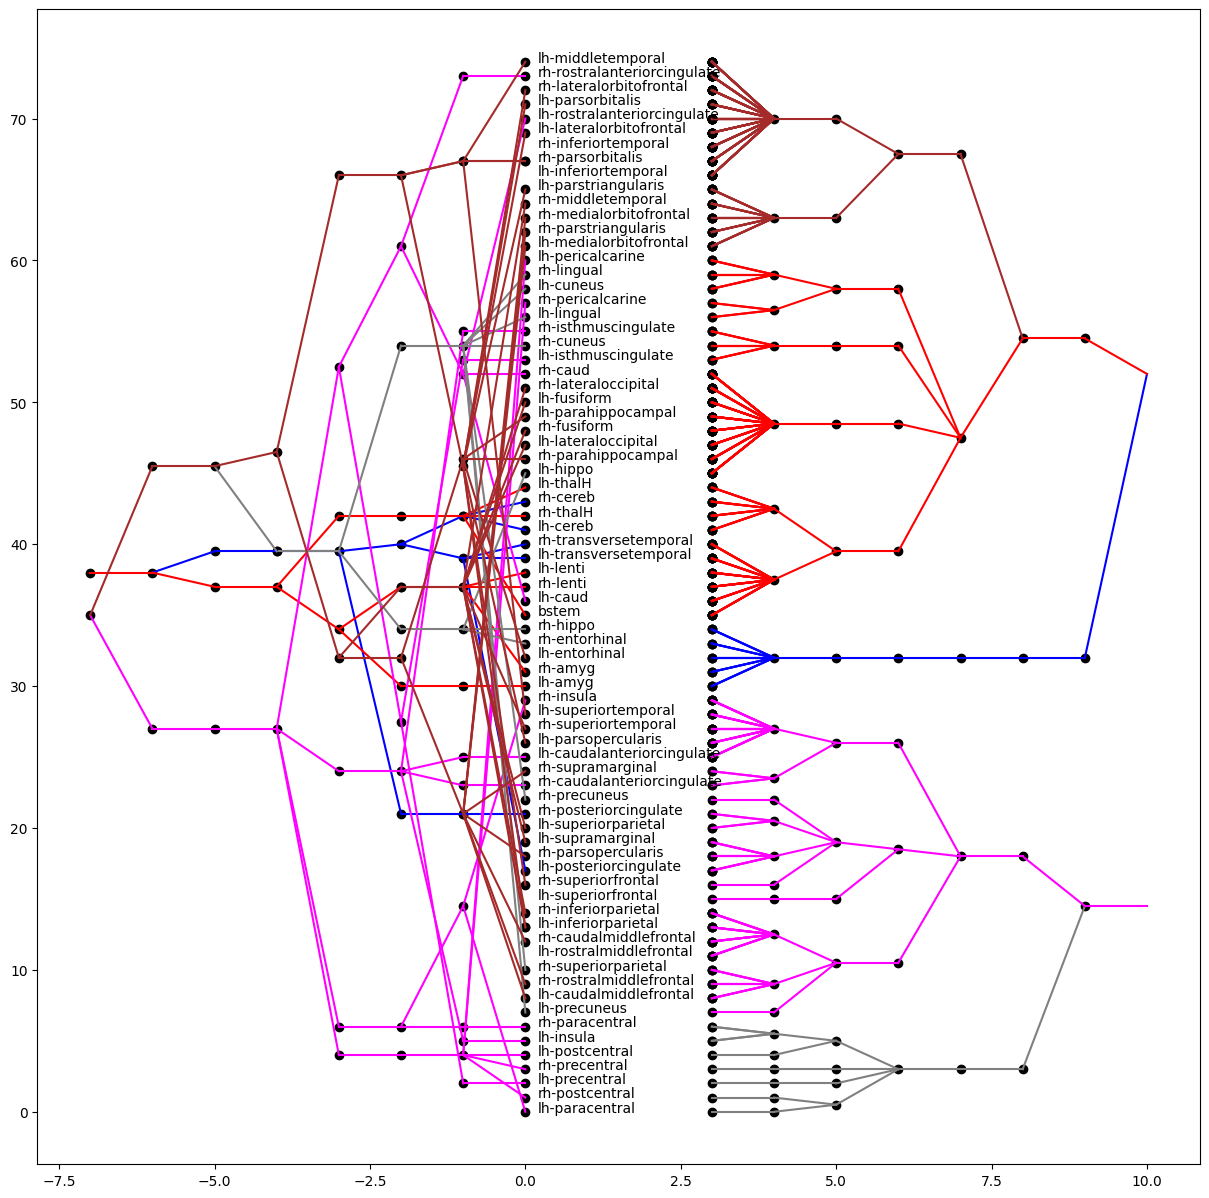

In [13]:
from scipy.stats import mode 

correlome = 'gc'
group = 'FT'


columns = ['{}_cls_{}_{}'.format(cls, group, correlome) for cls in cls_numbers for correlome in ['fc', 'gc']]
columns.append('name')

a = relabeled_clust_res.copy()
a = a[columns].sort_values(['{}_cls_{}_{}'.format(cls, group, 'fc') for cls in cls_numbers])
a.reset_index(drop=True, inplace=True)

number_of_colors = 75
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


color = ['blue', 'red', 'magenta', 'gray', 'brown', 'gold', 'black', 'aqua', 'orange', 'lime']

whole = np.arange(len(rois))
plt.figure(figsize=(15,15))

#plt.plot([np.zeros_like(whole), np.ones_like(whole)], 
#         [whole,whole], color='gray')

points = [75,25, 15,10,5,4,3,2]

correlome= 'gc'
for y, c in enumerate(points):
    #print(np.unique(a['{}_cls_FT_gc'.format(c)].values))
    for cluster in np.unique(a['{}_cls_{}_{}'.format(c, group, correlome )].values):
        
        idx = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster].index
        m = np.median(idx)
        #plt.vlines(-y, np.min(idx), np.max(idx), 'gray')
        
        if c != 2:
            previous = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster]['{}_cls_{}_{}'.format(points[y+1], group, correlome)].values
            previous = mode(previous, keepdims=True)[0][0]
            idx = a[a['{}_cls_{}_{}'.format(points[y+1], group, correlome)] == previous].index
            previous_m = np.median(idx)
            
            root = previous = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster]['{}_cls_{}_{}'.format(5, group, correlome)].values
            root = mode(root, keepdims=True)[0][0]
            
            
            #plt.hlines(m, -y, -y-1 , color[int(root)-1])
            #plt.vlines(-y-1, m, previous_m ,color[int(root)-1])
            
            plt.plot([-y, -y-1], [m, previous_m] ,color[int(root)-1])
            
            
        plt.scatter(-y, m,color='black')

correlome = 'fc'
for y, c in enumerate(points):
    #print(np.unique(a['{}_cls_FT_gc'.format(c)].values))
    for cluster in np.unique(a['{}_cls_{}_{}'.format(c, group, correlome )].values):
        idx = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster].index
        m = np.median(idx)
        #plt.vlines(-y, np.min(idx), np.max(idx), 'gray')
        
        if c != 2:
            previous = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster]['{}_cls_{}_{}'.format(points[y+1], group, correlome)].values
            previous = mode(previous, keepdims=True)[0][0]
            idx = a[a['{}_cls_{}_{}'.format(points[y+1], group, correlome)] == previous].index
            previous_m = np.median(idx)
            
            root = previous = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster]['{}_cls_{}_{}'.format(5, group, correlome)].values
            root = mode(root, keepdims=True)[0][0]
        
            if c == 75 and len(idx) > 1: 
                for each in idx:
                    plt.plot([y+3, y+4], [each, previous_m] ,color[int(root)-1])
                    plt.scatter(y+3, each ,color='black')
            else: 
                    plt.plot([y+3, y+4], [m, previous_m] ,color[int(root)-1])
                    plt.scatter(y+3, m,color='black')
        
        
        
for i, row in a.iterrows():
    plt.annotate(row['name'], (0.2,i))
plt.show()



## MUTUAL INFORMATION 

PT: Ses1 [2] [3]
PT: Ses2 [32] [8]
FT [5] [8]


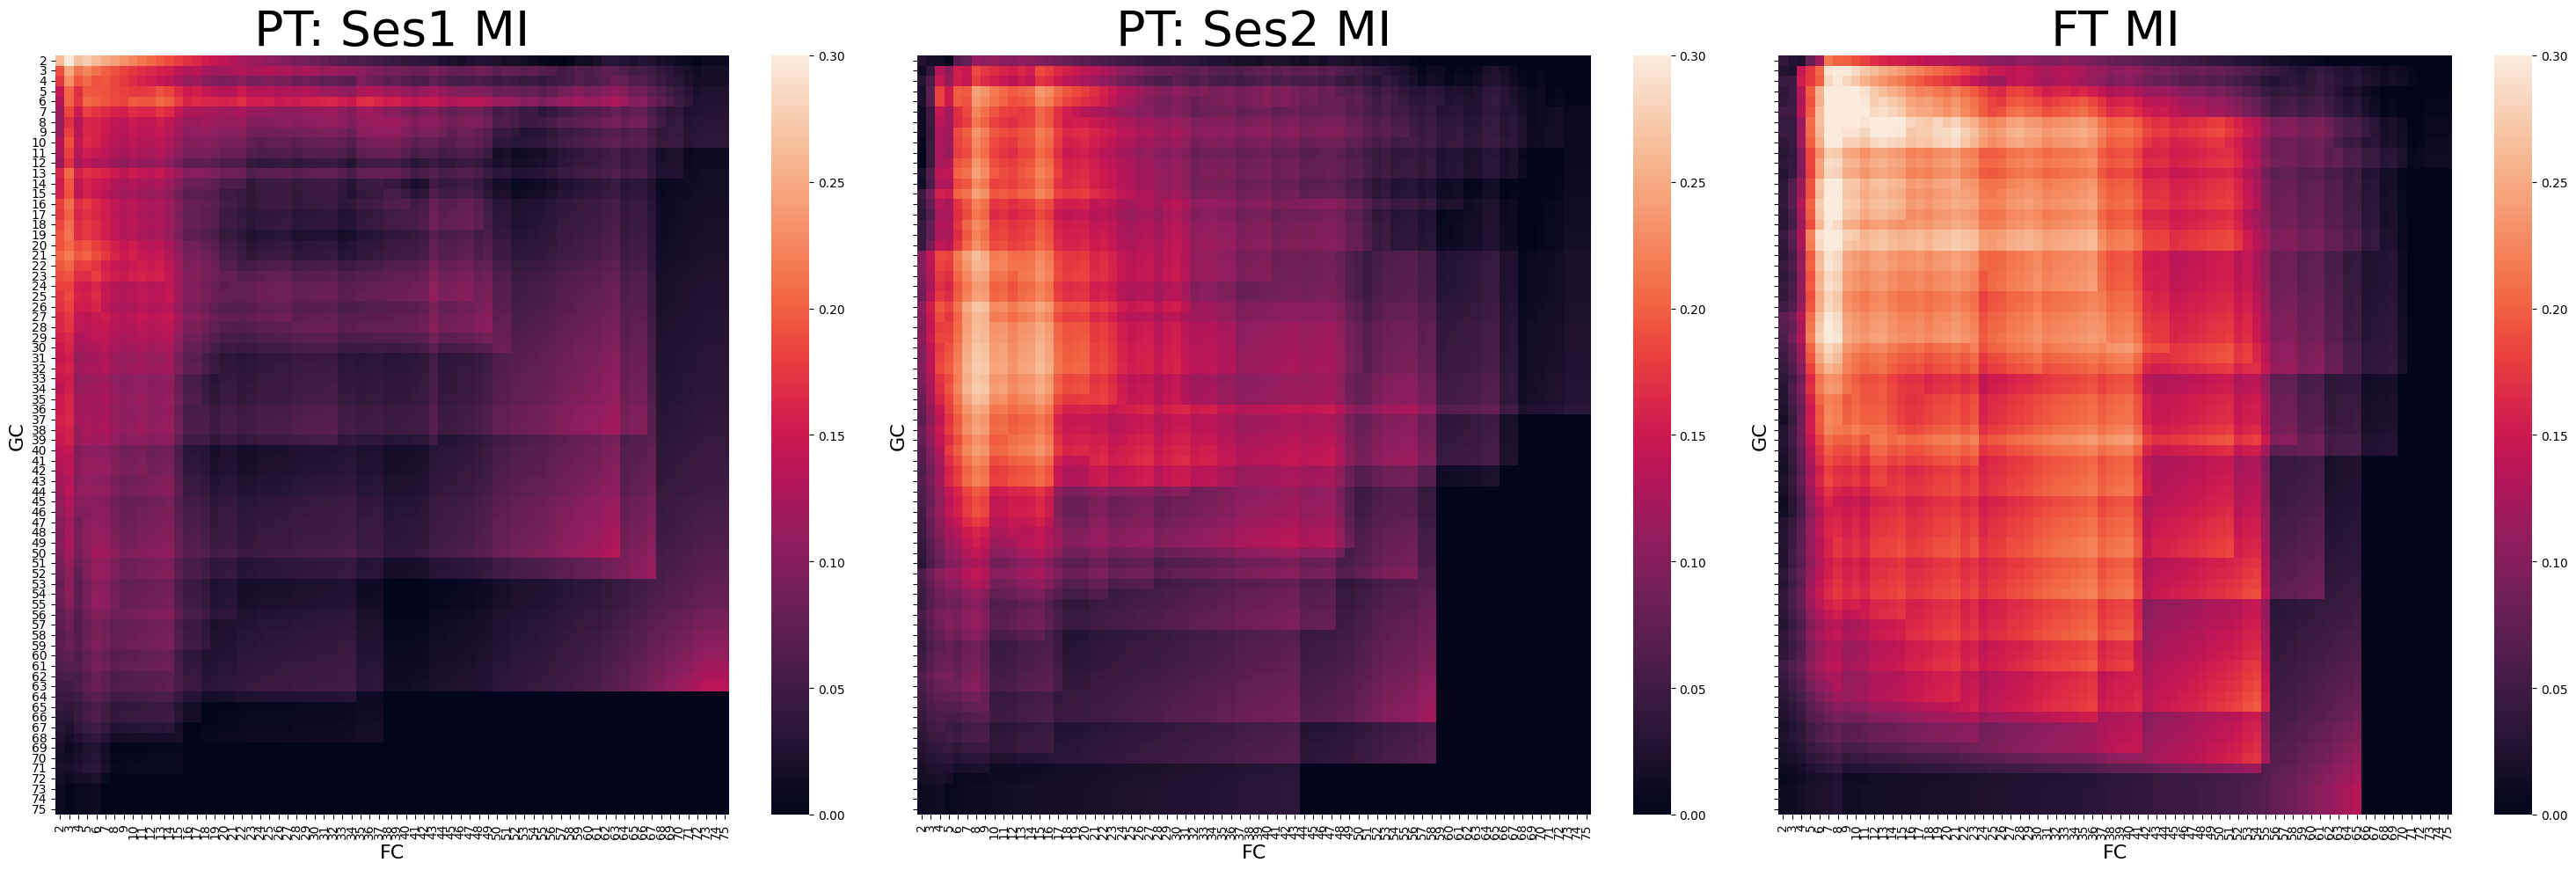

In [14]:
### MUTUAL INFORMATION PER GROUP
# before re-assign

fig, axs = plt.subplots(1,3, figsize=(30,10), sharex=True, sharey=True)
cmap = sns.color_palette("vlag", as_cmap=True)

mi_matrix = {}

for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    
    MI = np.zeros((len(cls_numbers),len(cls_numbers) ))
    for i in cls_numbers:
        for j in cls_numbers:
            ami =  adjusted_mutual_info_score(clusters['{}_cls_{}_{}'.format(i, group, 'gc')].values, 
                          clusters['{}_cls_{}_{}'.format(j, group, 'fc')].values)
            
            MI[i-2,j-2] = ami
    
    id_max = np.where(MI == MI.max())
    print(group, id_max[0]+2,id_max[1]+2 )
    
    mi_matrix[group] = MI 
    
    sns.heatmap(MI, 
            xticklabels=cls_numbers,
            yticklabels=cls_numbers, ax=axs[loc], vmin=0, vmax=0.3)
    axs[loc].set_title('{} MI'.format(group), fontsize=40)
    axs[loc].set_ylabel('GC', fontsize=16)
    axs[loc].set_xlabel('FC', fontsize=16)
 
plt.tight_layout()
plt.show()


In [15]:
for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    print(group, np.max(mi_matrix[group]))

PT: Ses1 0.3160284416441568
PT: Ses2 0.27600666986806605
FT 0.34179642262910326


PT: Ses1 [2] [5]
PT: Ses2 [21] [8]
FT [5] [7]


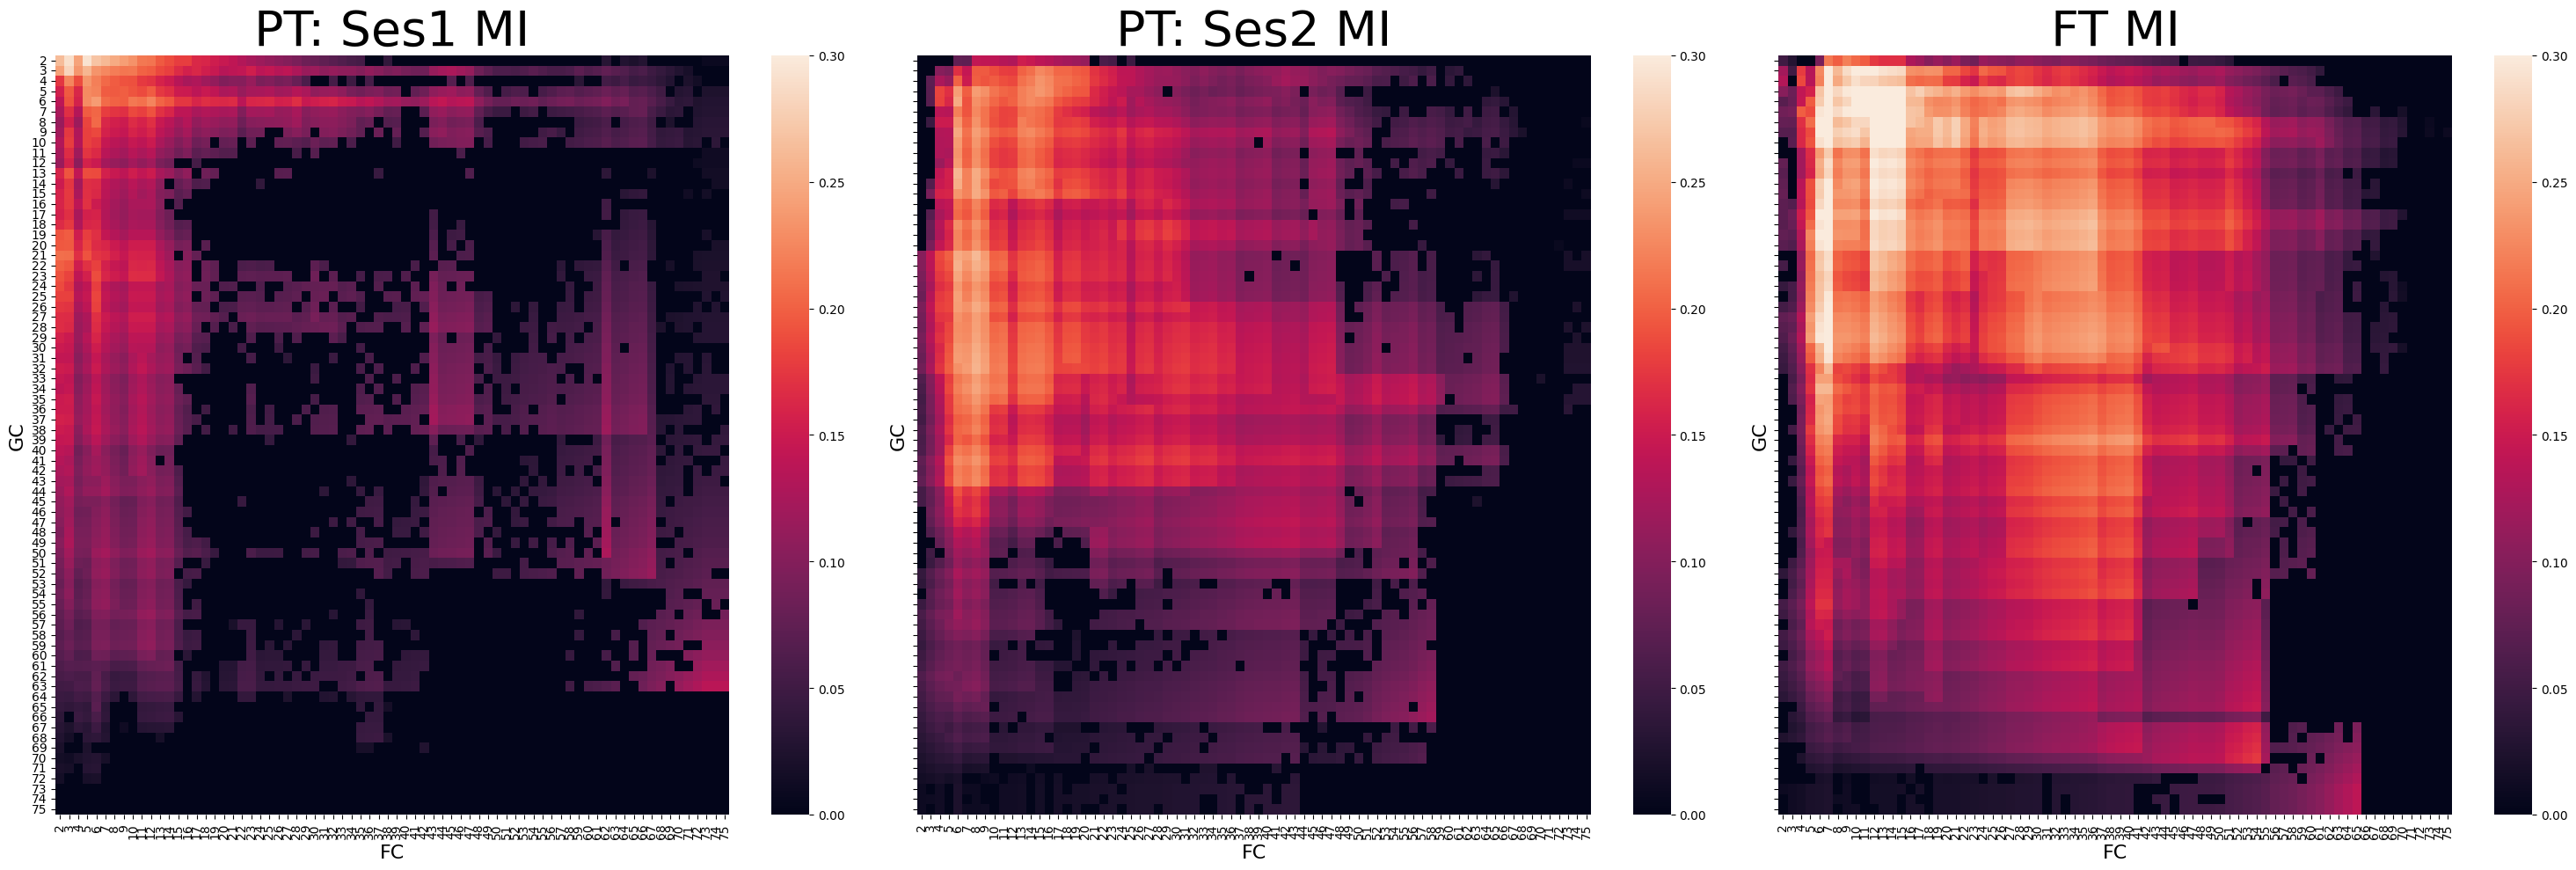

In [16]:
### MUTUAL INFORMATION PER GROUP
### include permutation testing 

def random_shuffle_labels(vector):
    m_ids = np.arange(len(vector))
    np.random.shuffle(m_ids)
    shuf = vector[m_ids].copy()
    return shuf

fig, axs = plt.subplots(1,3, figsize=(30,10), sharex=True, sharey=True)
cmap = sns.color_palette("vlag", as_cmap=True)

permut = 50

mi_matrix = {}

for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    
    MI = np.zeros((len(cls_numbers),len(cls_numbers) ))
    for i in cls_numbers:
        for j in cls_numbers:
            ami =  adjusted_mutual_info_score(clusters_post['{}_cls_{}_{}'.format(i, group, 'gc')].values, 
                          clusters_post['{}_cls_{}_{}'.format(j, group, 'fc')].values)
            null_MI = [adjusted_mutual_info_score(
                        random_shuffle_labels(clusters_post['{}_cls_{}_{}'.format(i, group, 'gc')].values), 
                        random_shuffle_labels(clusters_post['{}_cls_{}_{}'.format(j, group, 'fc')].values)) for p in range(permut)]
            
            null_MI.sort()
            if ami >= null_MI[-int(permut*0.05)]:
                MI[i-2,j-2] = ami
            else: 
                MI[i-2,j-2] = 0
    id_max = np.where(MI == MI.max())
    print(group, id_max[0]+2,id_max[1]+2 )
    
    mi_matrix[group] = MI 
    
    sns.heatmap(MI, 
            xticklabels=cls_numbers,
            yticklabels=cls_numbers, ax=axs[loc], vmin=0, vmax=0.3)
    axs[loc].set_title('{} MI'.format(group), fontsize=40)
    axs[loc].set_ylabel('GC', fontsize=16)
    axs[loc].set_xlabel('FC', fontsize=16)
 
plt.tight_layout()
plt.show()
# before re-assign


In [18]:
#import pickle
#with open('../../Results/GC_FC_paper/clustering/MI_permutation_groups.pickle', 'wb') as fp:
#    pickle.dump(mi_matrix, fp)

In [4]:
permut_matrix = pd.read_pickle('../../Results/GC_FC_paper/clustering/MI_permutation_groups.pickle')

In [5]:
for_comparing = {}

for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    MI = permut_matrix[group] 
    print('{}: mean MI {:.3f} (std {:.3f})'.format(group, np.mean(MI[MI!=0]), np.std(MI[MI!=0]) ))
    
    for_comparing[group] = MI[MI!=0].ravel()
    print(len(for_comparing[group]))

PT: Ses1: mean MI 0.083 (std 0.044)
2712
PT: Ses2: mean MI 0.111 (std 0.054)
3866
FT: mean MI 0.144 (std 0.067)
4408


In [6]:
from scipy import stats 
stats.levene(for_comparing['PT: Ses2'],for_comparing['FT'])

LeveneResult(statistic=152.2211852589361, pvalue=1.1425746403673982e-34)

In [7]:
kr = pd.DataFrame(np.array([np.concatenate([for_comparing['PT: Ses2'],for_comparing['FT']]), 
             np.concatenate([np.zeros_like(for_comparing['PT: Ses2']),np.ones_like(for_comparing['FT'])])]).T, columns =['data', 'group'] 
        )

pg.kruskal(kr, 'data', 'group' )

Source  ddof1           H          p-unc
Kruskal  group      1  507.088127  2.727459e-112

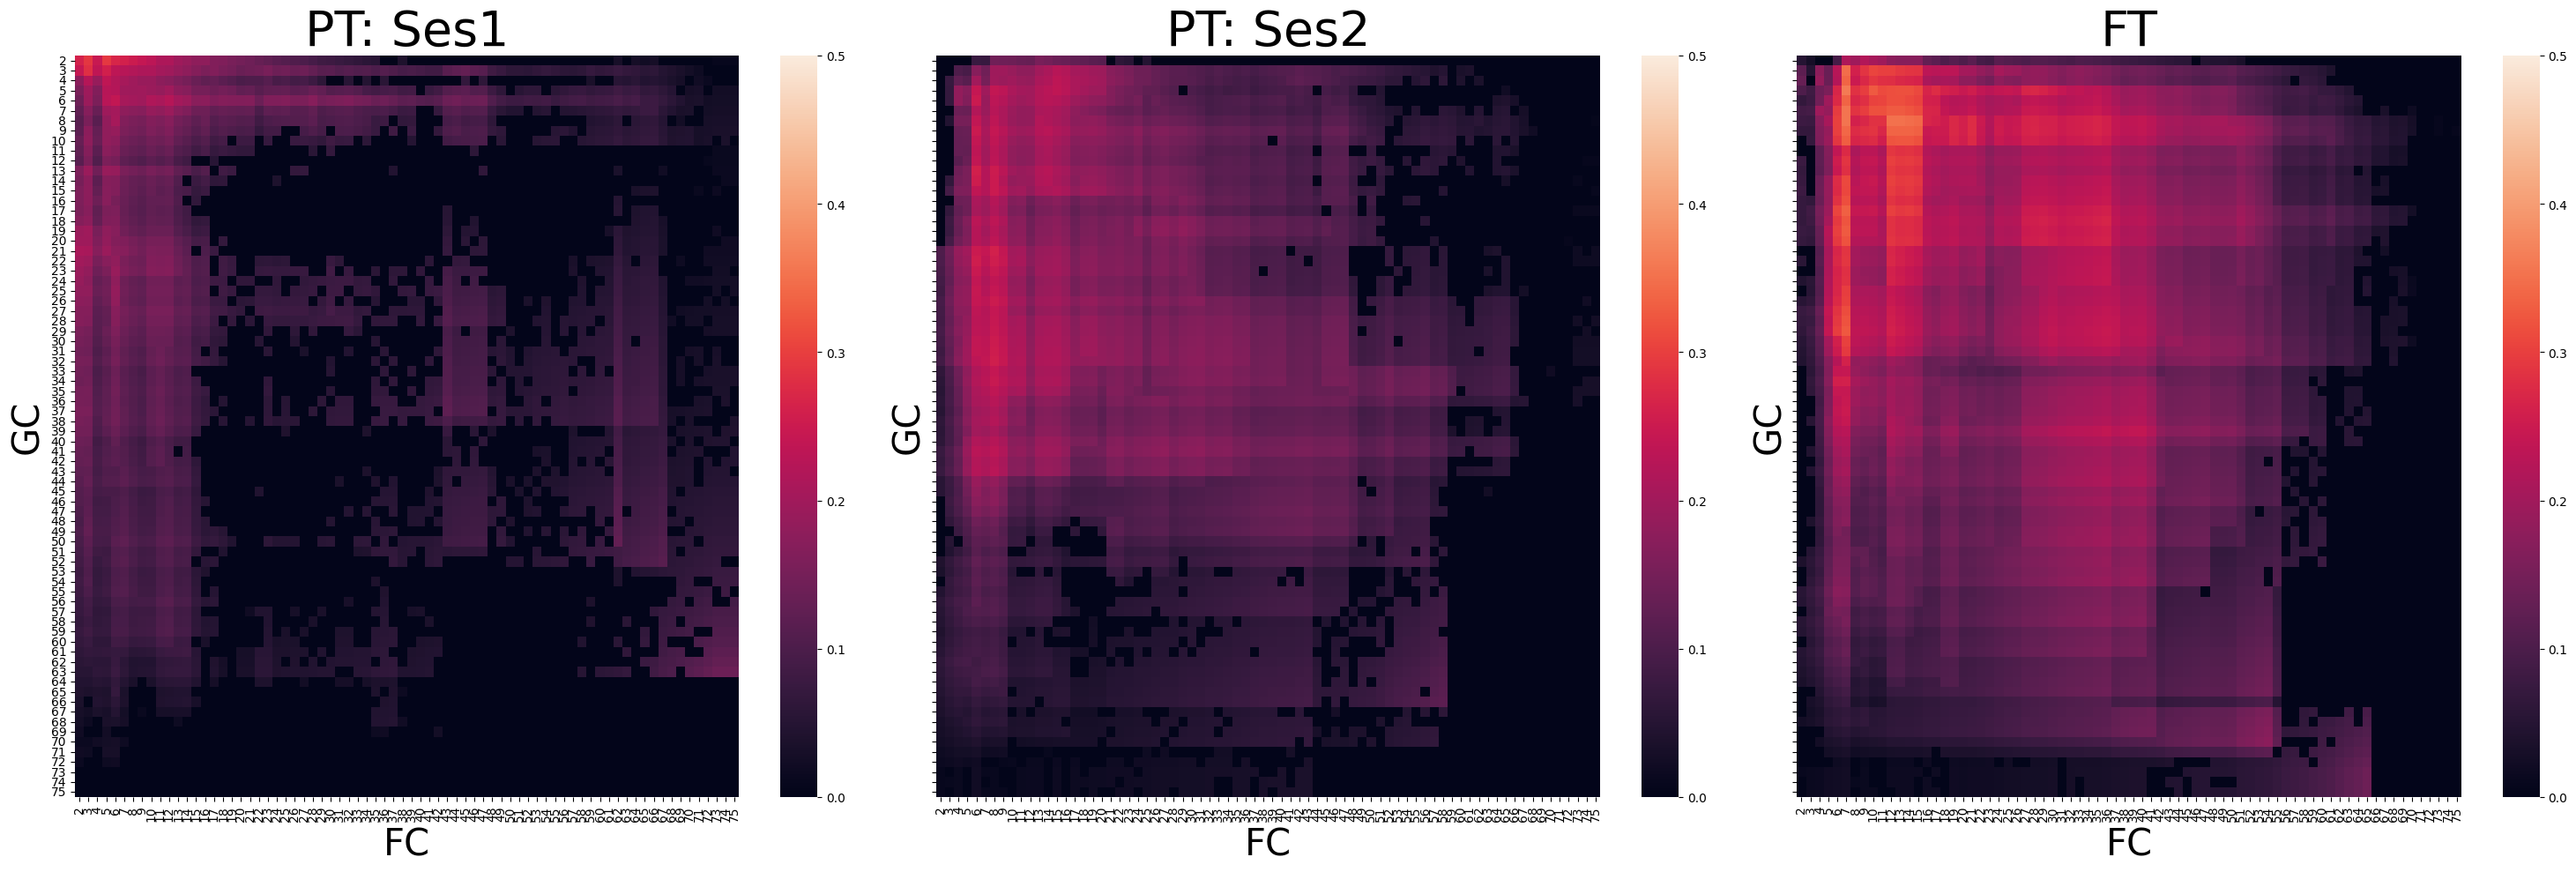

In [8]:
fig, axs = plt.subplots(1,3, figsize=(30,10), sharex=True, sharey=True)
cmap = sns.color_palette("vlag", as_cmap=True)

cls_numbers = np.arange(74)+2

for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    
    MI = permut_matrix[group] 
    sns.heatmap(MI, 
            xticklabels=cls_numbers,
            yticklabels=cls_numbers, ax=axs[loc], vmin=0, vmax=0.5)
    axs[loc].set_title('{}'.format(group), fontsize=40)
    axs[loc].set_ylabel('GC', fontsize=30)
    axs[loc].set_xlabel('FC', fontsize=30)
 
plt.tight_layout()
plt.savefig('../../Results/GC_FC_paper/figures/GC_FC_connectome_MI_permuted.jpg', dpi=300)
plt.show()
# before re-assign


In [9]:
for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    print(group, np.max(permut_matrix[group]))

PT: Ses1 0.2928690239398287
PT: Ses2 0.2611803654875518
FT 0.36120981116954815


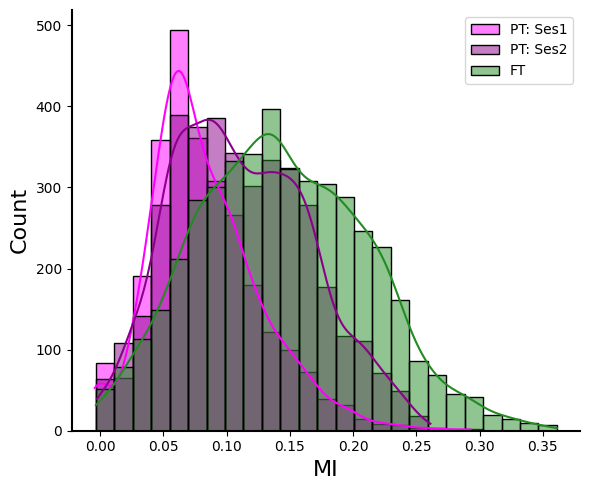

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

colors = {
   'PT: Ses1' : 'magenta', 
    'PT: Ses2': 'darkmagenta', 
    'FT' :'forestgreen' 
    
}

m = permut_matrix['FT'].ravel()
bins_a = np.histogram_bin_edges(m[m!=0], bins=25)

for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    m = permut_matrix[group].ravel()
    #bins_a = np.histogram_bin_edges(m[m!=0], bins=25)
    sns.histplot(m[m!=0], color=colors[group],bins=bins_a, ax=ax, kde=True, label=group)
  

ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('MI', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)
    
#plt.xlim(-0.01,.37)
#plt.ylim(-0.01,800)

#plt.xlim(-0.01,1.01)
#plt.ylim(-0.01,800)
        
plt.legend()
plt.tight_layout()
#plt.savefig('../../Results/GC_FC_paper/update_figures/GC_FC_connectome_MI_groups.jpg', dpi=300)
plt.show()

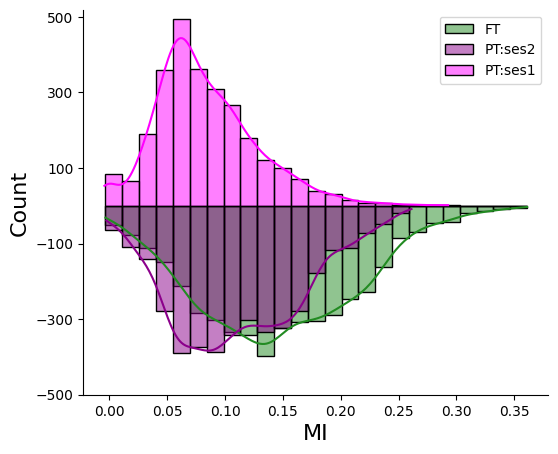

In [27]:
colors = {
   'PT: Ses1' : 'magenta', 
    'PT: Ses2': 'darkmagenta', 
    'FT' :'forestgreen'    
}

labels = {
   'PT: Ses1' : 'PT:ses1', 
    'PT: Ses2': 'PT:ses2', 
    'FT' :'FT'    
}


fig, ax = plt.subplots(1,1,figsize=(6,5), sharey=True)

m = permut_matrix['FT'].ravel()
bins_a = np.histogram_bin_edges(m[m!=0], bins=25)


for loc, group in enumerate([ 'FT','PT: Ses2']):
    m = permut_matrix[group].ravel()
    #bins_a = np.histogram_bin_edges(m[m!=0], bins=25)
    sns.histplot(m[m!=0],  color=colors[group],bins=bins_a, ax=ax, kde=True, label=labels[group])

for p in ax.patches:  # turn the histogram upside down
    p.set_height(-p.get_height())
for l in ax.lines:  # turn the kde curve upside down
    l.set_ydata(-l.get_ydata())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)   

m = permut_matrix['PT: Ses1'].ravel()
sns.histplot(m[m!=0], color='magenta', bins=bins_a,ax=ax, kde=True, label='PT:ses1') 
ax.set_yticks(np.arange(-500, 501, 200))   
#ax.spines['bottom'].set_position('zero')
ax.set_xlabel('MI', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('', fontsize=18)
plt.legend()
plt.savefig('../../Results/GC_FC_paper/update_figures/split_GC_FC_connectome_MI_groups.jpg', dpi=300)
plt.show()

In [43]:
## test for normality 

values = np.array([permut_matrix['PT: Ses1'].ravel(), 
                   permut_matrix['PT: Ses2'].ravel(), 
                   permut_matrix['FT'].ravel()])#.ravel()
#df_for_anova= pd.DataFrame(values.T, columns=['Ses1', 'Ses2', 'FT'])
comp= pd.DataFrame(values.T, columns=['Ses1', 'Ses2', 'FT'])


for i, ses in enumerate(['Ses1', 'Ses2', 'FT']):
    norm = pg.normality(comp[ses])
    flag = True
    if norm.normal.values == False:
        print(ses, 'is not normal')
        flag = False
if flag == False: 
    test = pg.friedman(comp) #, method="f")
   
print(test)
print()
print('Computing non-parametric..')
print()

## paired Wilcoxon test
p_vals = []

p_vals.append(pg.wilcoxon(comp['Ses1'], comp['Ses2'], alternative='two-sided', correction=True)['p-val'].values[0])
p_vals.append(pg.wilcoxon(comp['Ses1'], comp['FT'], alternative='two-sided', correction=True)['p-val'].values[0])
p_vals.append(pg.wilcoxon(comp['Ses2'],comp['FT'], alternative='two-sided', correction=True)['p-val'].values[0])

_, p_vals = pg.multicomp(p_vals, method='fdr_bh')

print('Paired wilcoxon: ', p_vals)

## Compare shape of the distribution

#from scipy import stats => compare the distribution of the correlome 
p_vals = []

_, p = stats.kstest(comp['Ses1'], comp['Ses2'], alternative='two-sided')
p_vals.append(p)
_, p = stats.kstest(comp['Ses1'],comp['FT'], alternative='two-sided')
p_vals.append(p)
_, p = stats.kstest(comp['Ses2'], comp['FT'], alternative='two-sided')
p_vals.append(p)

_, p_vals = pg.multicomp(p_vals, method='fdr_bh')

print('Kolmogorov-Smirnov: ', p_vals)

/volatile/miniconda3/envs/networks/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/volatile/miniconda3/envs/networks/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/volatile/miniconda3/envs/networks/lib/python3.10/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Ses1 is not normal
Ses2 is not normal
FT is not normal
          Source         W  ddof1            Q  p-unc
Friedman  Within  0.328556      2  3598.343383    0.0

Computing non-parametric..

Paired wilcoxon:  [3.55246486e-296 0.00000000e+000 0.00000000e+000]
Kolmogorov-Smirnov:  [7.81383261e-156 0.00000000e+000 3.10238514e-102]


In [23]:
'''
### MUTUAL INFORMATION PER GROUP

# after re-assign
fig, axs = plt.subplots(1,3, figsize=(30,10), sharex=True, sharey=True)
cmap = sns.color_palette("vlag", as_cmap=True)

mi_matrix = {}

for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    
    MI = np.zeros((len(cls_numbers),len(cls_numbers) ))
    for i in cls_numbers:
        for j in cls_numbers:
            ami =  adjusted_mutual_info_score(clusters_post['{}_cls_{}_{}'.format(i, group, 'gc')].values, 
                          clusters_post['{}_cls_{}_{}'.format(j, group, 'fc')].values)
            
            MI[i-2,j-2] = ami
    
    id_max = np.where(MI == MI.max())
    print(group, id_max[0]+2,id_max[1]+2 )
    
    mi_matrix[group] = MI 
    
    sns.heatmap(MI, 
            xticklabels=cls_numbers,
            yticklabels=cls_numbers, ax=axs[loc], vmin=0, vmax=0.3)
    axs[loc].set_title('{} MI'.format(group), fontsize=40)
    axs[loc].set_ylabel('GC', fontsize=16)
    axs[loc].set_xlabel('FC', fontsize=16)
 
plt.tight_layout()
plt.show()


for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    print(group, np.max(mi_matrix[group]))
    
'''


'\n### MUTUAL INFORMATION PER GROUP\n\nfig, axs = plt.subplots(1,3, figsize=(30,10), sharex=True, sharey=True)\ncmap = sns.color_palette("vlag", as_cmap=True)\n\nmi_matrix = {}\n\nfor loc, group in enumerate([\'PT: Ses1\', \'PT: Ses2\', \'FT\']):\n    \n    MI = np.zeros((len(cls_numbers),len(cls_numbers) ))\n    for i in cls_numbers:\n        for j in cls_numbers:\n            ami =  adjusted_mutual_info_score(clusters_post[\'{}_cls_{}_{}\'.format(i, group, \'gc\')].values, \n                          clusters_post[\'{}_cls_{}_{}\'.format(j, group, \'fc\')].values)\n            \n            MI[i-2,j-2] = ami\n    \n    id_max = np.where(MI == MI.max())\n    print(group, id_max[0]+2,id_max[1]+2 )\n    \n    mi_matrix[group] = MI \n    \n    sns.heatmap(MI, \n            xticklabels=cls_numbers,\n            yticklabels=cls_numbers, ax=axs[loc], vmin=0, vmax=0.3)\n    axs[loc].set_title(\'{} MI\'.format(group), fontsize=40)\n    axs[loc].set_ylabel(\'GC\', fontsize=16)\n    axs[loc].se

In [12]:
### group wise 
mi_groups = {}

for pair in [['PT: Ses1', 'PT: Ses2'],['PT: Ses1', 'FT'],['FT', 'PT: Ses2']]:
    
    print(pair)
    
    for correlome in ['gc', 'fc']:
            
        MI = np.zeros((len(cls_numbers),len(cls_numbers) ))
        for i in cls_numbers:
            for j in cls_numbers:
                
                ami =  adjusted_mutual_info_score(clusters_post['{}_cls_{}_{}'.format(i, pair[0], correlome)].values, 
                          clusters_post['{}_cls_{}_{}'.format(j, pair[1], correlome)].values)
            
                MI[i-2,j-2] = ami
                
        mi_groups['{}vs{}_{}'.format(pair[0], pair[1], correlome)] = MI 
    
        print(correlome, np.max(MI))
    

['PT: Ses1', 'PT: Ses2']
gc 0.37792825948617864
fc 0.7450632578770708
['PT: Ses1', 'FT']
gc 0.38170632520424674
fc 0.7450632578770708
['FT', 'PT: Ses2']
gc 1.0
fc 1.0


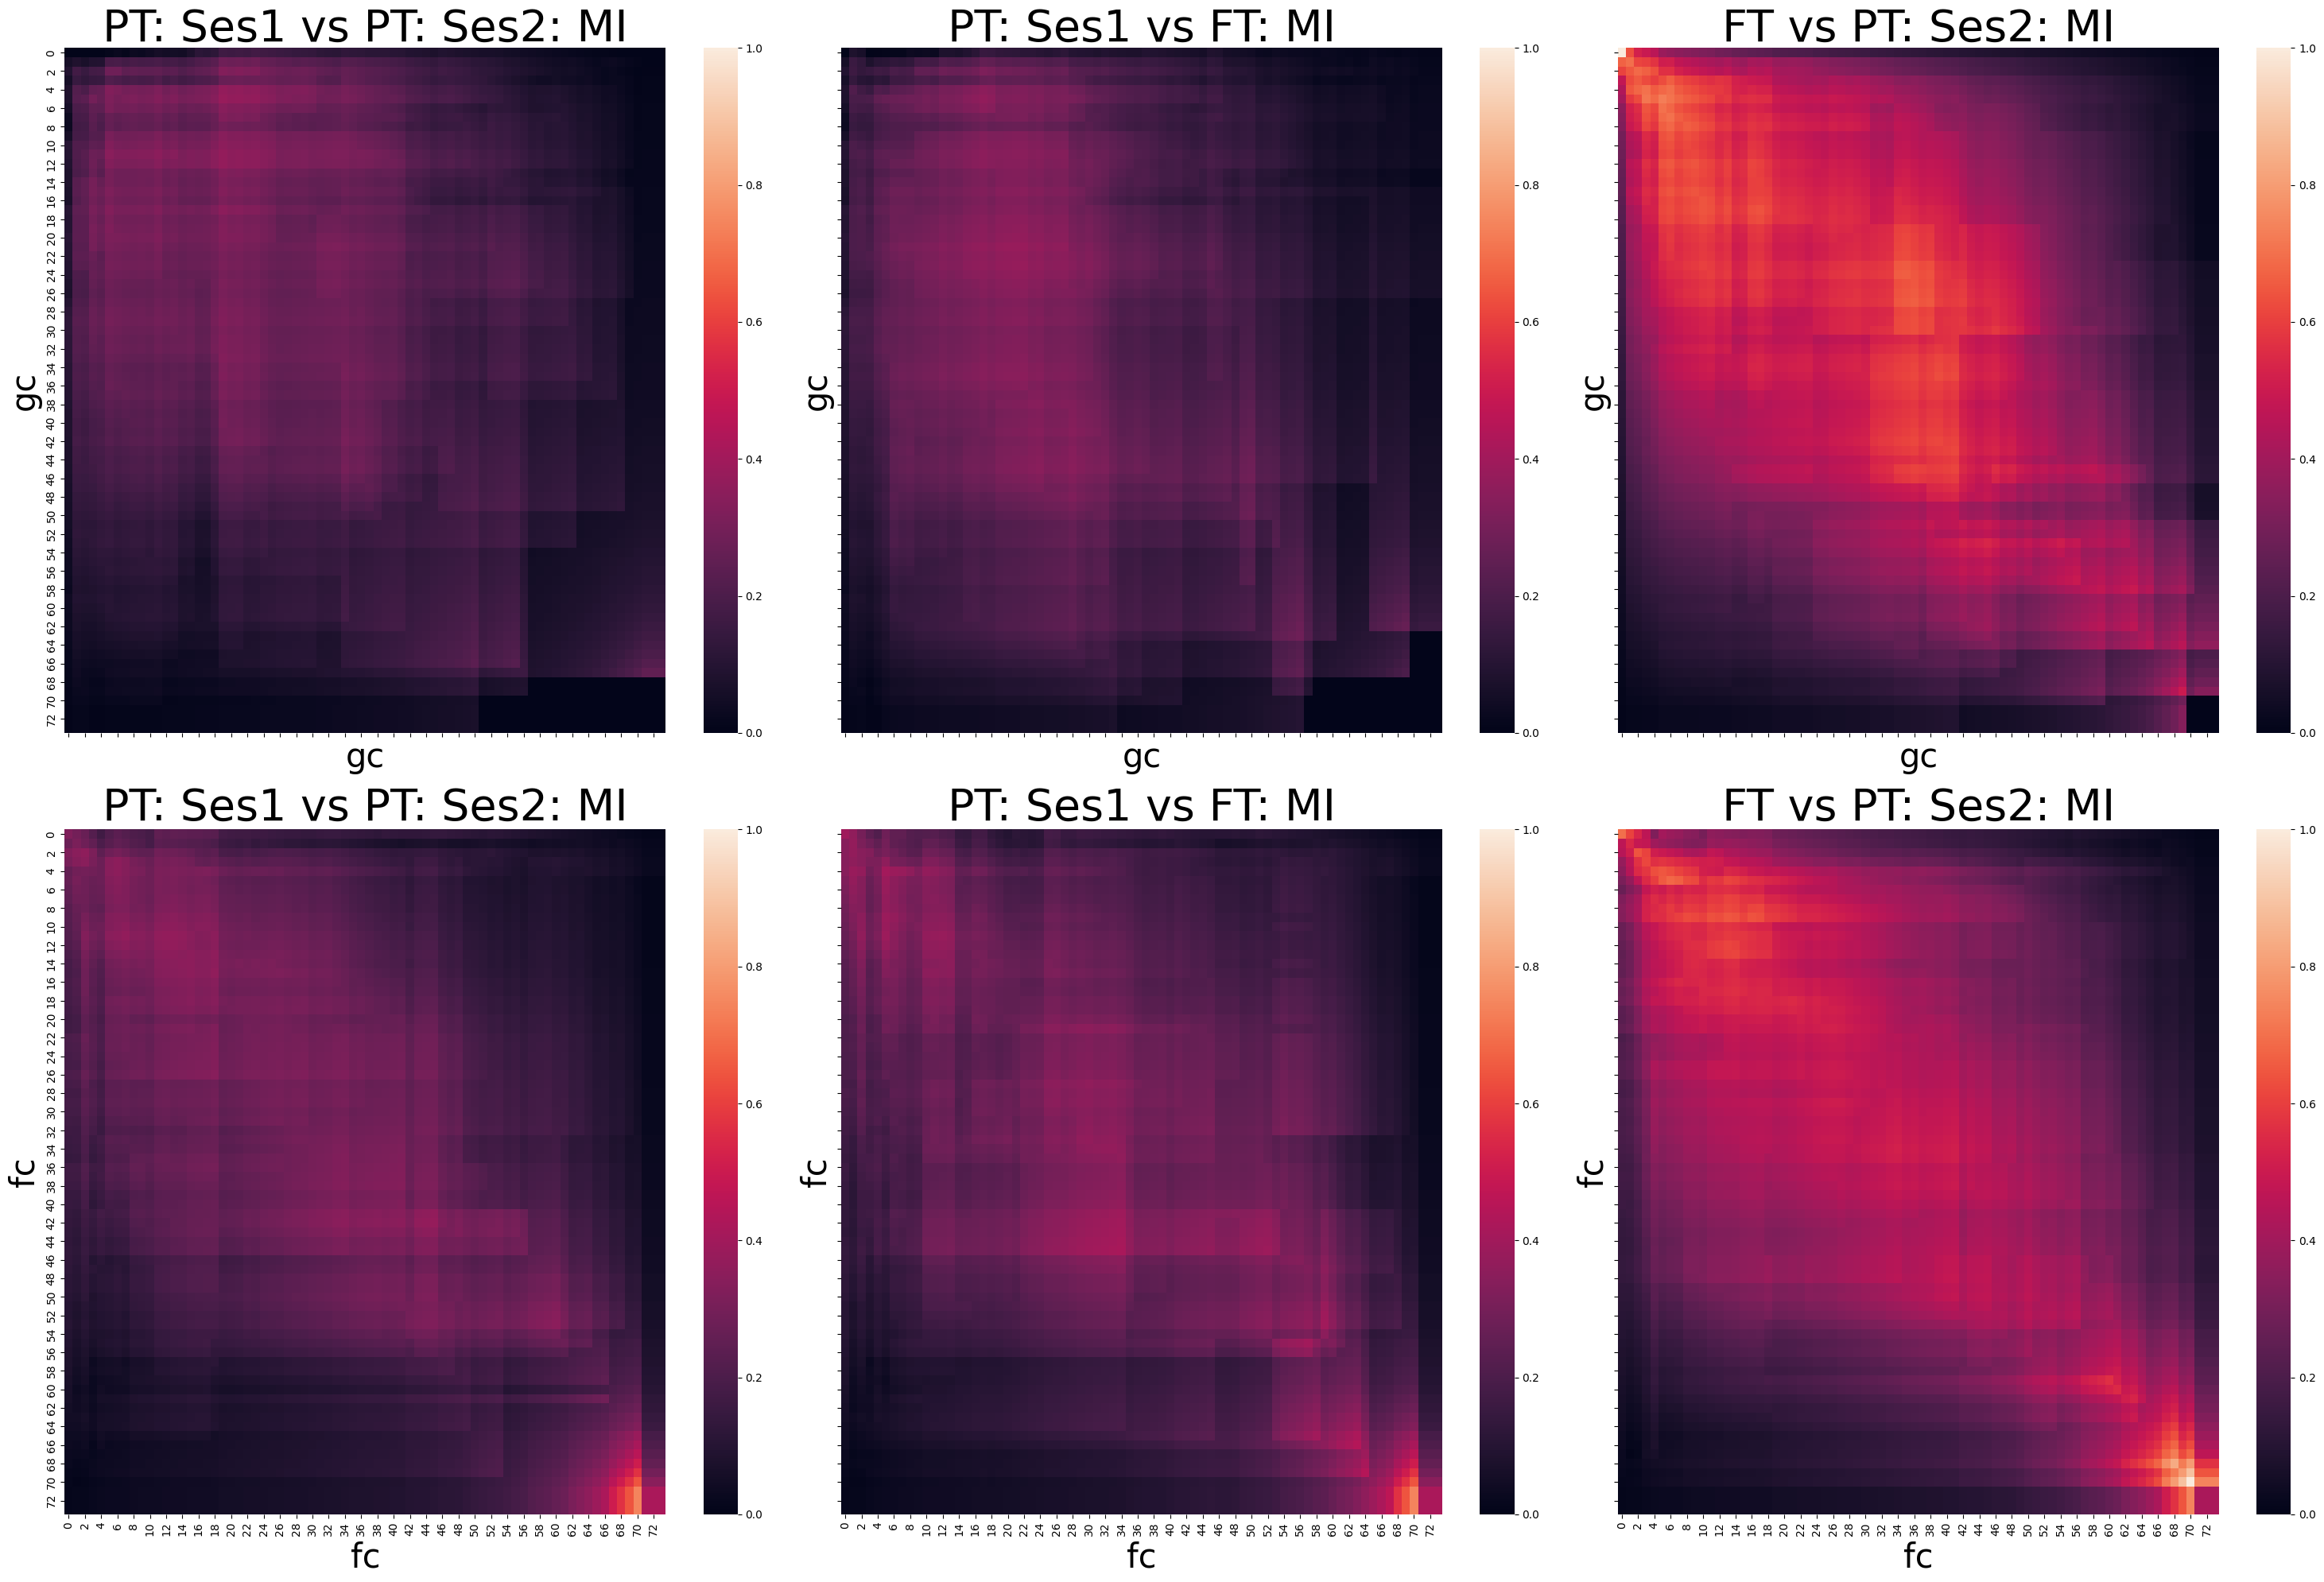

In [13]:
fig, axs = plt.subplots(2,3, figsize=(30,20), sharex=True, sharey=True)
#cmap = sns.color_palette("vlag", as_cmap=True)

for p, pair in enumerate([['PT: Ses1', 'PT: Ses2'],['PT: Ses1', 'FT'],['FT', 'PT: Ses2']]):
    for c, correlome in enumerate(['gc', 'fc']):

        sns.heatmap(mi_groups['{}vs{}_{}'.format(pair[0], pair[1], correlome)], ax=axs[c,p],  vmin=0, vmax=1)
    
        axs[c,p].set_title('{} vs {}: MI'.format(pair[0], pair[1]), fontsize=40)
        axs[c,p].set_ylabel(correlome, fontsize=30)
        axs[c,p].set_xlabel(correlome, fontsize=30)
plt.tight_layout()
plt.show()

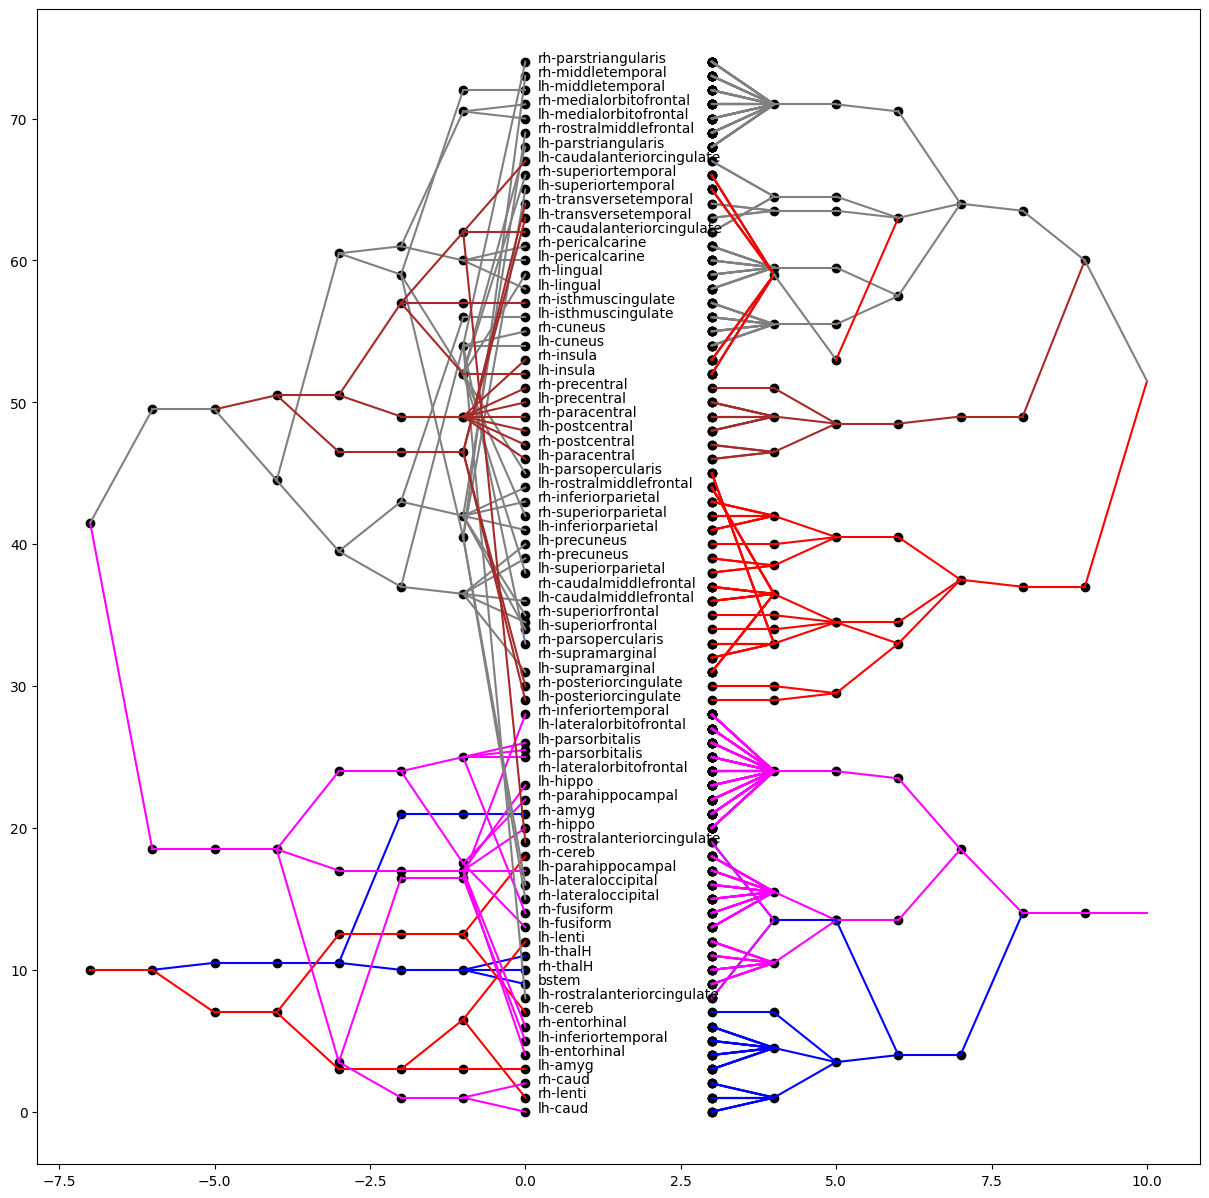

In [547]:
from scipy.stats import mode 

correlome = 'gc'
group = 'FT'


columns = ['{}_cls_{}_{}'.format(cls, group, correlome) for cls in cls_numbers for correlome in ['fc', 'gc']]
columns.append('name')

a = relabeled_clust_res.copy()
a = a[columns].sort_values(['{}_cls_{}_{}'.format(cls, group, 'fc') for cls in cls_numbers])
a.reset_index(drop=True, inplace=True)

number_of_colors = 75
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


color = ['blue', 'red', 'magenta', 'gray', 'brown', 'gold', 'black', 'aqua', 'orange', 'lime']

whole = np.arange(len(rois))
plt.figure(figsize=(15,15))

#plt.plot([np.zeros_like(whole), np.ones_like(whole)], 
#         [whole,whole], color='gray')

points = [75,25, 15,10,5,4,3,2]

correlome= 'gc'
for y, c in enumerate(points):
    #print(np.unique(a['{}_cls_FT_gc'.format(c)].values))
    for cluster in np.unique(a['{}_cls_{}_{}'.format(c, group, correlome )].values):
        
        idx = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster].index
        m = np.median(idx)
        #plt.vlines(-y, np.min(idx), np.max(idx), 'gray')
        
        if c != 2:
            previous = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster]['{}_cls_{}_{}'.format(points[y+1], group, correlome)].values
            previous = mode(previous, keepdims=True)[0][0]
            idx = a[a['{}_cls_{}_{}'.format(points[y+1], group, correlome)] == previous].index
            previous_m = np.median(idx)
            
            root = previous = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster]['{}_cls_{}_{}'.format(5, group, correlome)].values
            root = mode(root, keepdims=True)[0][0]
            
            
            #plt.hlines(m, -y, -y-1 , color[int(root)-1])
            #plt.vlines(-y-1, m, previous_m ,color[int(root)-1])
            
            plt.plot([-y, -y-1], [m, previous_m] ,color[int(root)-1])
            
            
        plt.scatter(-y, m,color='black')

correlome = 'fc'
for y, c in enumerate(points):
    #print(np.unique(a['{}_cls_FT_gc'.format(c)].values))
    for cluster in np.unique(a['{}_cls_{}_{}'.format(c, group, correlome )].values):
        idx = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster].index
        m = np.median(idx)
        #plt.vlines(-y, np.min(idx), np.max(idx), 'gray')
        
        if c != 2:
            previous = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster]['{}_cls_{}_{}'.format(points[y+1], group, correlome)].values
            previous = mode(previous, keepdims=True)[0][0]
            idx = a[a['{}_cls_{}_{}'.format(points[y+1], group, correlome)] == previous].index
            previous_m = np.median(idx)
            
            root = previous = a[a['{}_cls_{}_{}'.format(c, group, correlome)] == cluster]['{}_cls_{}_{}'.format(5, group, correlome)].values
            root = mode(root, keepdims=True)[0][0]
        
            if c == 75 and len(idx) > 1: 
                for each in idx:
                    plt.plot([y+3, y+4], [each, previous_m] ,color[int(root)-1])
                    plt.scatter(y+3, each ,color='black')
            else: 
                    plt.plot([y+3, y+4], [m, previous_m] ,color[int(root)-1])
                    plt.scatter(y+3, m,color='black')
        
        
        
for i, row in a.iterrows():
    plt.annotate(row['name'], (0.2,i))
plt.show()


